In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.2 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import gc
# from keras.applications import DenseNet121
from tensorflow.keras.models import Model
# from tensorflow.keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Lambda, BatchNormalization
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import os
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
import tensorflow_addons as tfa

import logging
import pickle


In [ ]:
BASE_PATH = "/content/gdrive/MyDrive/KaggleDataBTP/gaussian_filtered_images/"

In [ ]:
# logging.basicConfig(filename = "cro.log", level=logging.DEBUG, filemode='w+', format='%(name)s - %(levelname)s - %(message)s')

In [ ]:
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def buildfinetunemodel():
    input = tf.keras.Input(shape=1024)
    x = tf.keras.layers.Dropout(0.5)(input)
    x= tf.keras.layers.Dense(1024,activation='relu')(x)
    x= tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.Dense(1024,activation='relu')(x)
    output=tf.keras.layers.Dense(4,activation='softmax')(x)
    finetune_model = tf.keras.Model(input, output)
    finetune_model.compile(loss='categorical_crossentropy',
                metrics=['accuracy', f1_m])


    return finetune_model

In [ ]:
finetune_model = buildfinetunemodel()
finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 2,103,300
Trainable params: 2,103,300
Non-train

In [ ]:
data_x = np.load(BASE_PATH + "data_x.npy")
data_y = np.load(BASE_PATH + "data_y.npy")
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.15)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2948, 1024)
(2948,)
(521, 1024)
(521,)


In [ ]:
train_y_one_hot = np.zeros((train_y.size, 4))
train_y_one_hot[np.arange(train_y.size),train_y] = 1
train_y_one_hot

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [ ]:
test_y_one_hot = np.zeros((test_y.size, 4))
test_y_one_hot[np.arange(test_y.size),test_y] = 1
test_y_one_hot

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
import random
import copy
import sys
import os
import sys
from tqdm import tqdm
import heapq

initializer = tf.keras.initializers.HeNormal()
vars = finetune_model.trainable_variables
loss_fn = keras.losses.SparseCategoricalCrossentropy()
acc_fn = tf.keras.metrics.Accuracy()

num_molecule = 20
mole_coll = 0.3
KE_loss_rate = 0.1
buffer = 400

In [ ]:
class Molecule:
    def __init__(self, vars = None, weights = None, velocity = None, ke = None, num_hit = None, local_best = None):
        if weights:
            self.weights = weights
        elif vars:
            self.weights = [initializer(shape=s.shape) for s in vars]
        # self.f1_metric = tfa.metrics.F1Score(num_classes=4)
        # self.ck_metric = tfa.metrics.CohenKappa(num_classes=4, sparse_labels=True)
        self.PE, self.acc = self.get_loss()

        self.KE = 1
        self.TE = self.PE + self.KE
        self.val_loss, self.val_acc = self.get_loss_val()

        if velocity:
            self.velocity = velocity
        else:
            self.velocity = [tf.random.normal(shape=s.shape, stddev = 0.1) for s in vars] #, minval = -1, maxval=1

        self.num_hit = 0 # How many time the perticular molecule exploited its search space.

        self.local_best = self.weights

    def update_best(self):
        if self.PE < self.get_loss_weight(self.local_best)[0]:
            self.local_best = self.weights

    def update_PE(self):
        self.PE, self.acc = self.get_loss()
        self.val_loss, self.val_acc = self.get_loss_val()

    def get_loss_weight(self, weight):
        finetune_model.set_weights(weights=weight)
        logits = finetune_model(train_x)
        loss_value = loss_fn(train_y, logits)
        acc_value = acc_fn(train_y, np.argmax(logits, axis = 1))
        return loss_value, acc_value

    def get_loss(self):
        finetune_model.set_weights(weights=self.weights)
        logits = finetune_model(train_x)

        loss_value = loss_fn(train_y, logits)
        acc_value = acc_fn(train_y, np.argmax(logits, axis = 1))

        # self.f1_metric.update_state(train_y_one_hot, logits)
        # f1_result = self.f1_metric.result()

        # self.ck_metric.update_state(train_y , np.argmax(logits, axis = 1))
        # ck_result = self.ck_metric.result()

        return (loss_value, acc_value)

    def get_loss_val(self):
        finetune_model.set_weights(weights=self.weights)
        logits = finetune_model(test_x)

        loss_value = loss_fn(test_y, logits)
        acc_value = acc_fn(test_y, np.argmax(logits, axis = 1))

        # self.f1_metric.update_state(test_y_one_hot, logits)
        # f1_result = self.f1_metric.result()

        # self.ck_metric.update_state(test_y , np.argmax(logits, axis = 1))
        # ck_result = self.ck_metric.result()

        return (loss_value, acc_value)

In [ ]:
def create_molecule():
    m = Molecule(vars)
    m.velocity = [(global_best[i]- m.weights[i]) for i in range(len(global_best))]
    return m

def pso_update(m):
    r1 = random.random()
    r2 = random.random()
    first_term = [w*l_v for l_v in m.velocity]
    second_term = [c1*r1*x for x in [(m.local_best[i]- m.weights[i]) for i in range(len(m.local_best))]]
    third_term = [c2*r2*x for x in [(global_best[i]- m.weights[i]) for i in range(len(global_best))]]
    m.velocity = [m.KE * (first_term[i] + second_term[i] + third_term[i]) for i in range(len(first_term))]

    m.weights = [(m.weights[i]+ m.velocity[i]) for i in range(len(m.weights))]
    m.update_PE()
    m.num_hit = 0
    m.update_best()
    if m.PE > 10:
        m = create_molecule()
    del first_term
    del second_term
    del third_term
    gc.collect()
    return m

def neighbourhood(m, learning_rate):

    with tf.GradientTape(watch_accessed_variables=False) as t:
        t.reset()
        t.watch(finetune_model.trainable_variables)
        finetune_model.set_weights(weights=m.weights)
        logits = finetune_model(train_x)
        loss_value = loss_fn(train_y, logits)

    gradients = t.gradient(loss_value, finetune_model.trainable_weights)

    new_weights = []
    for i in range(len(finetune_model.trainable_weights)):
        layer = finetune_model.trainable_weights[i]
        layer =  layer - learning_rate * gradients[i]
        new_weights.append(layer)

    m.weights = new_weights
    m.update_PE()
    if m.PE > 10:
        m = create_molecule()
    del gradients
    del new_weights
    gc.collect()
    return m

def onwall_ineffective_collision(m):
    return neighbourhood(m, 0.01)

def onwall_criteria(m_old, m_new):
    pe_new = m_new.PE
    if (m_old[0] + m_old[1] >= pe_new):
        return True
    else:
        return False

def intermol_criteria(m1, m2, m1_new, m2_new):
    pe1 = m1_new.PE
    pe2 = m2_new.PE
    if (m1[0] + m1[1] + m2[0] + m2[1] >= pe1 + pe2):
        return True
    else:
        return False

def intermol_ineffective_collision(m1, m2):
    return (neighbourhood(m1, 0.01), neighbourhood(m2, 0.01)) #instead of creating new

def best_molecule():
    bm = molecule[0]
    for m in molecule:
        if m.PE < bm.PE:
            bm = m
    return bm


def execute_intermol_ineffective_collision(m1, m2, i, j):
    global buffer
    # m1_copy = copy.deepcopy(m1)
    # m2_copy = copy.deepcopy(m2)

    pe_x1 = copy.deepcopy(m1.PE)
    pe_x2 = copy.deepcopy(m2.PE)
    ke_x1 = copy.deepcopy(m1.KE)
    ke_x2 = copy.deepcopy(m2.KE)

    (m1_new, m2_new) = intermol_ineffective_collision(m1, m2)
    if(intermol_criteria((pe_x1, ke_x1), (pe_x2, ke_x2), m1_new, m2_new)):
        # pe_x1 = m1_copy.PE
        # pe_x2 = m2_copy.PE
        # ke_x1 = m1_copy.KE
        # ke_x2 = m2_copy.KE
        p = random.random()
        m1_new.KE = (pe_x1 + pe_x2 + ke_x1 + ke_x2 - m1_new.PE - m2_new.PE) * p
        m2_new.KE = (pe_x1 + pe_x2 + ke_x1 + ke_x2 - m1_new.PE - m2_new.PE) * (1-p)

        m1_new.num_hit += 1
        m2_new.num_hit += 1

        m1_new.update_best()
        m2_new.update_best()

        if tf.math.is_nan(m1_new.PE) or tf.math.is_nan(m2_new.PE):
            print("NaN Occured Here")
            sys.exit()
        # molecule.append(m1_new)
        # molecule.append(m2_new)

        molecule[i] = m1_new
        molecule[j] = m2_new

        logging.info(f"Current PE : {m1_new.PE} , {m2_new.PE}")
        return True
    else:
        return False

def execute_onwall_collision(m_old, i):
    global buffer
    # m_old_copy = copy.deepcopy(m_old)
    pe_m_old = copy.deepcopy(m_old.PE)
    ke_m_old = copy.deepcopy(m_old.KE)

    m_new = onwall_ineffective_collision(m_old)
    if onwall_criteria((pe_m_old, ke_m_old), m_new):
        p1 = random.uniform(KE_loss_rate, 1)
        pe_new = m_new.PE
        ke_new = m_new.KE = (pe_m_old - pe_new + ke_m_old) * p1
        buffer = buffer + ((pe_m_old - pe_new + ke_m_old)*(1-p1))
        m_new.num_hit += 1
        m_new.update_best()
        if tf.math.is_nan(m_new.PE):
            print("NaN Occured Here")
            os._exit(0)


        # molecule.append(m_new)
        molecule[i] = m_new
        logging.info(f"Current PE : {m_new.PE}")
        return True
    else:
        return False

def execute_pso_upadte(m_old, i):
    global buffer
    m_new = pso_update(m_old)
    if tf.math.is_nan(m_new.PE):
        print("NaN Occured Here")
        os._exit(0)
    molecule[i] = m_new
    logging.info(f"Current PE : {m_new.PE}")



def save_molecules(molecules, file_name1 = "molecule_weights"):
    file_name = BASE_PATH + file_name1
    molecule_to_save = []
    for m in molecule:
        molecule_to_save.append([m.weights, m.velocity, m.num_hit, m.KE, m.local_best])
    with open(file_name, "wb") as fp:
        pickle.dump(molecule_to_save, fp)

def read_molecule(file_name1 = "molecule_weights"):
    file_name = BASE_PATH + file_name1
    with open(file_name, "rb") as fp:
        molecules_meta_data = pickle.load(fp)
    molecules = []
    for m_data in molecules_meta_data:
        molecules.append(Molecule(weights=m_data[0], velocity=m_data[1], num_hit = m_data[2], ke = m_data[3], local_best= m_data[4]))
    return molecules

In [ ]:
molecule = []
for i in tqdm(range(num_molecule)):
    m = Molecule(vars)
    # m_new = neighbourhood(m, 0.01)
    molecule.append(m)

100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


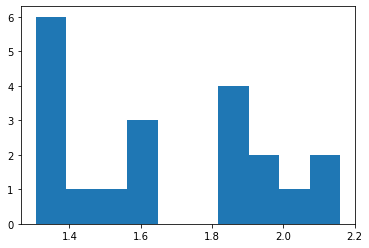

In [ ]:
allPE = []
for m in molecule:
    allPE.append(m.PE)

import matplotlib.pyplot as plt
plt.hist(allPE)
plt.show()

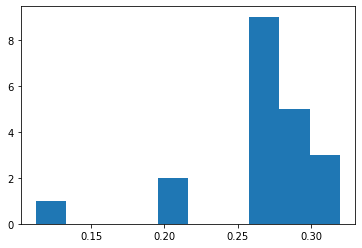

In [ ]:
allAcc = []
for m in molecule:
    allAcc.append(m.acc)

import matplotlib.pyplot as plt
plt.hist(allAcc)
plt.show()

In [ ]:
molecule_pe_before = []
for m in molecule:
    molecule_pe_before.append(m.PE)

molecule_acc_before = []
for m in molecule:
    molecule_acc_before.append(m.acc)

# molecule_f1_before = []
# for m in molecule:
#     molecule_f1_before.append(m.f1_score)

# molecule_ck_before = []
# for m in molecule:
#     molecule_ck_before.append(m.ck_score)


In [ ]:
print(f"\nMinimum PE {best_molecule().PE}")

y = 40
w = float(0.3)
c1 = float(0.1)
c2 = float(0.9)
global_best = best_molecule().weights


Minimum PE 1.3057348728179932


In [ ]:
loss_history = []
val_loss_history = []
acc_history = []
val_acc_history = []
# ck_history = []
# val_ck_history = []



loss_history_epochs = []
val_loss_history_epochs = []
acc_history_epochs = []
val_acc_history_epochs = []
# ck_history_epochs = []
# val_ck_history_epochs = []

In [ ]:
num_epochs = 500
e = 0
while(1):
    print(f"Epochs : {e+1}")
    for idx in tqdm(range(len(molecule))):
        # idx = random.randint(0, len(molecule)-1)
        m = molecule[idx]
        # molecule.pop(idx)
        if m.num_hit > y:
            execute_pso_upadte(m, idx)
            logging.info(f"Epochs : {e+1}\tPSO Update ")
        else:
            r = random.random()
            if r > 0.5:
                i = random.randint(0, len(molecule)-1)
                m1 = molecule[i]
                # molecule.pop(i)
                if execute_intermol_ineffective_collision(m, m1, idx, i):
                    logging.info(f"Epochs : {e+1}\tInter Mole ")
                else:
                    logging.info(f"Epochs : {e+1}\tNone ")
                    molecule[idx].num_hit += 1
                    molecule[i].num_hit += 1
                    # molecule.append(m)
                    # molecule.append(m1)
            else:
                if execute_onwall_collision(m, idx):
                    logging.info(f"Epochs : {e+1}\tOn wall ")
                else:
                    logging.info(f"Epochs : {e+1}\tNone ")
                    molecule[idx].num_hit += 1
                    # molecule.append(m)

        global_best_mole = best_molecule()
        global_best = global_best_mole.weights
        loss_history.append(global_best_mole.PE)
        val_loss_history.append(global_best_mole.val_loss)
        acc_history.append(global_best_mole.acc)
        val_acc_history.append(global_best_mole.val_acc)
        # ck_history.append(global_best_mole.ck_score)
        # val_ck_history.append(global_best_mole.val_ck_score)



    print(f"Loss : {global_best_mole.PE}, Val Loss : {global_best_mole.val_loss} Acc : {global_best_mole.acc}, Val Acc : {global_best_mole.val_acc}")
    # print(f"F1 : {global_best_mole.f1_score} Val F1 : {global_best_mole.val_f1_score} CK : {global_best_mole.ck_score} val_CK : {global_best_mole.val_ck_score}")
    loss_history_epochs.append(global_best_mole.PE)
    val_loss_history_epochs.append(global_best_mole.val_loss)
    acc_history_epochs.append(global_best_mole.acc)
    val_acc_history_epochs.append(global_best_mole.val_acc)
    # ck_history_epochs.append(global_best_mole.ck_score)
    # val_ck_history_epochs.append(global_best_mole.val_ck_score)


    e += 1
    if e == num_epochs:
        break

Epochs : 1


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 1.3451707363128662, Val Loss : 1.3063671588897705 Acc : 0.3239443004131317, Val Acc : 0.32387712597846985
Epochs : 2


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 1.0825392007827759, Val Loss : 1.0491139888763428 Acc : 0.35819199681282043, Val Acc : 0.3586098253726959
Epochs : 3


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.883448600769043, Val Loss : 0.8556553721427917 Acc : 0.36602771282196045, Val Acc : 0.36636918783187866
Epochs : 4


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


Loss : 0.8513786196708679, Val Loss : 0.868495762348175 Acc : 0.37866073846817017, Val Acc : 0.37888994812965393
Epochs : 5


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.8323857188224792, Val Loss : 0.8189100623130798 Acc : 0.418738454580307, Val Acc : 0.41892021894454956
Epochs : 6


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.753970205783844, Val Loss : 0.766963541507721 Acc : 0.4581243693828583, Val Acc : 0.458243727684021
Epochs : 7


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.7414360046386719, Val Loss : 0.738530158996582 Acc : 0.4908040761947632, Val Acc : 0.49090704321861267
Epochs : 8


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.718595027923584, Val Loss : 0.7144373655319214 Acc : 0.5312149524688721, Val Acc : 0.5312798023223877
Epochs : 9


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.7129861116409302, Val Loss : 0.7005820274353027 Acc : 0.5405900478363037, Val Acc : 0.5406560897827148
Epochs : 10


100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


Loss : 0.7080222368240356, Val Loss : 0.7020893096923828 Acc : 0.5612528920173645, Val Acc : 0.5613003969192505
Epochs : 11


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.7033984661102295, Val Loss : 0.6922740936279297 Acc : 0.576202929019928, Val Acc : 0.5762468576431274
Epochs : 12


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Loss : 0.6889337301254272, Val Loss : 0.6815769076347351 Acc : 0.5977428555488586, Val Acc : 0.5977798104286194
Epochs : 13


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.6807284355163574, Val Loss : 0.6735101342201233 Acc : 0.6042567491531372, Val Acc : 0.6042914986610413
Epochs : 14


100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Loss : 0.6697253584861755, Val Loss : 0.6607211828231812 Acc : 0.611042857170105, Val Acc : 0.6110748648643494
Epochs : 15


100%|██████████| 20/20 [00:05<00:00,  3.33it/s]


Loss : 0.6663558483123779, Val Loss : 0.6593492031097412 Acc : 0.6205525398254395, Val Acc : 0.6205803751945496
Epochs : 16


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.6631065607070923, Val Loss : 0.6541903614997864 Acc : 0.6286224126815796, Val Acc : 0.628646969795227
Epochs : 17


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.6599879264831543, Val Loss : 0.6531113982200623 Acc : 0.6355850696563721, Val Acc : 0.6356070041656494
Epochs : 18


100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


Loss : 0.6540976166725159, Val Loss : 0.647348940372467 Acc : 0.6423707604408264, Val Acc : 0.6423903107643127
Epochs : 19


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.6512988805770874, Val Loss : 0.6425313353538513 Acc : 0.6489637494087219, Val Acc : 0.6489810347557068
Epochs : 20


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.6485994458198547, Val Loss : 0.6420045495033264 Acc : 0.6541421413421631, Val Acc : 0.654158353805542
Epochs : 21


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.645990788936615, Val Loss : 0.6373061537742615 Acc : 0.6584262251853943, Val Acc : 0.6584406495094299
Epochs : 22


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


Loss : 0.6410378217697144, Val Loss : 0.632418155670166 Acc : 0.6627445220947266, Val Acc : 0.6627576947212219
Epochs : 23


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Loss : 0.636385440826416, Val Loss : 0.6278280019760132 Acc : 0.6684272885322571, Val Acc : 0.6684392094612122
Epochs : 24


100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


Loss : 0.6341667175292969, Val Loss : 0.6281659007072449 Acc : 0.6708657741546631, Val Acc : 0.6708779335021973
Epochs : 25


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.6320120692253113, Val Loss : 0.6235013604164124 Acc : 0.674264132976532, Val Acc : 0.6742749810218811
Epochs : 26


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Loss : 0.6323752999305725, Val Loss : 0.6234879493713379 Acc : 0.6773216724395752, Val Acc : 0.677331805229187
Epochs : 27


100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


Loss : 0.6264204382896423, Val Loss : 0.621973991394043 Acc : 0.6824718117713928, Val Acc : 0.6824811100959778
Epochs : 28


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.6227831244468689, Val Loss : 0.6186617612838745 Acc : 0.6839215755462646, Val Acc : 0.6839305758476257
Epochs : 29


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.6193829774856567, Val Loss : 0.6155919432640076 Acc : 0.6866033673286438, Val Acc : 0.6866114139556885
Epochs : 30


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Loss : 0.6177489161491394, Val Loss : 0.6086245179176331 Acc : 0.6881068348884583, Val Acc : 0.688115119934082
Epochs : 31


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.6162111163139343, Val Loss : 0.6127875447273254 Acc : 0.6902279257774353, Val Acc : 0.6902359127998352
Epochs : 32


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.6147090196609497, Val Loss : 0.6054062843322754 Acc : 0.6923642754554749, Val Acc : 0.692371666431427
Epochs : 33


100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Loss : 0.613037109375, Val Loss : 0.6071790456771851 Acc : 0.6947445869445801, Val Acc : 0.6947510838508606
Epochs : 34


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Loss : 0.6084898114204407, Val Loss : 0.6070795655250549 Acc : 0.6976407170295715, Val Acc : 0.6976473331451416
Epochs : 35


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Loss : 0.6056320071220398, Val Loss : 0.604266345500946 Acc : 0.6988281607627869, Val Acc : 0.6988345384597778
Epochs : 36


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


Loss : 0.6029019951820374, Val Loss : 0.6016132831573486 Acc : 0.7008203268051147, Val Acc : 0.7008262872695923
Epochs : 37


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.5990239381790161, Val Loss : 0.5931033492088318 Acc : 0.7031077146530151, Val Acc : 0.7031136155128479
Epochs : 38


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Loss : 0.5978015065193176, Val Loss : 0.5967553853988647 Acc : 0.7043350338935852, Val Acc : 0.7043407559394836
Epochs : 39


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.5954276919364929, Val Loss : 0.5945724248886108 Acc : 0.7060800194740295, Val Acc : 0.7060854434967041
Epochs : 40


100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


Loss : 0.5942640900611877, Val Loss : 0.5882429480552673 Acc : 0.7075080275535583, Val Acc : 0.7075132131576538
Epochs : 41


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.593151867389679, Val Loss : 0.5925382375717163 Acc : 0.709017276763916, Val Acc : 0.7090222239494324
Epochs : 42


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


Loss : 0.5920414328575134, Val Loss : 0.585952639579773 Acc : 0.7103870511054993, Val Acc : 0.7103918194770813
Epochs : 43


100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


Loss : 0.5909934043884277, Val Loss : 0.5906684994697571 Acc : 0.7117813229560852, Val Acc : 0.711786150932312
Epochs : 44


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Loss : 0.5889672636985779, Val Loss : 0.5889744758605957 Acc : 0.7131061553955078, Val Acc : 0.713110625743866
Epochs : 45


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.5879721641540527, Val Loss : 0.5816394686698914 Acc : 0.7143771052360535, Val Acc : 0.7143810391426086
Epochs : 46


100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


Loss : 0.587062656879425, Val Loss : 0.5874404311180115 Acc : 0.7154693603515625, Val Acc : 0.7154737114906311
Epochs : 47


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.5861395001411438, Val Loss : 0.579627275466919 Acc : 0.7166951298713684, Val Acc : 0.7166988253593445
Epochs : 48


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Loss : 0.5853166580200195, Val Loss : 0.5861124992370605 Acc : 0.7178443670272827, Val Acc : 0.717848539352417
Epochs : 49


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Loss : 0.5844577550888062, Val Loss : 0.577716588973999 Acc : 0.7190872430801392, Val Acc : 0.7190907001495361
Epochs : 50


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Loss : 0.5823605060577393, Val Loss : 0.5840827226638794 Acc : 0.7207366824150085, Val Acc : 0.7207400798797607
Epochs : 51


100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


Loss : 0.5816838145256042, Val Loss : 0.5742740631103516 Acc : 0.7213733196258545, Val Acc : 0.7213764190673828
Epochs : 52


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Loss : 0.580609917640686, Val Loss : 0.5727719664573669 Acc : 0.7225151062011719, Val Acc : 0.7225181460380554
Epochs : 53


100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


Loss : 0.5806116461753845, Val Loss : 0.5727733373641968 Acc : 0.7235130071640015, Val Acc : 0.7235159873962402
Epochs : 54


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Loss : 0.5802649855613708, Val Loss : 0.5831433534622192 Acc : 0.7244833111763, Val Acc : 0.7244862914085388
Epochs : 55


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Loss : 0.579794704914093, Val Loss : 0.5714770555496216 Acc : 0.7255032658576965, Val Acc : 0.7255062460899353
Epochs : 56


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Loss : 0.5796147584915161, Val Loss : 0.5831667184829712 Acc : 0.7263513207435608, Val Acc : 0.7263538837432861
Epochs : 57


100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


Loss : 0.5792532563209534, Val Loss : 0.5704283118247986 Acc : 0.7272030115127563, Val Acc : 0.7272058725357056
Epochs : 58


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Loss : 0.5790521502494812, Val Loss : 0.569642186164856 Acc : 0.7284101843833923, Val Acc : 0.7284128665924072
Epochs : 59


100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


Loss : 0.5789568424224854, Val Loss : 0.5705457329750061 Acc : 0.7288433909416199, Val Acc : 0.7288460731506348
Epochs : 60


100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


Loss : 0.5773444175720215, Val Loss : 0.5689886212348938 Acc : 0.729762077331543, Val Acc : 0.7297648787498474
Epochs : 61


100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


Loss : 0.5750063061714172, Val Loss : 0.5667756199836731 Acc : 0.7304647564888, Val Acc : 0.7304674983024597
Epochs : 62


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


Loss : 0.5734934210777283, Val Loss : 0.5653316974639893 Acc : 0.7316653728485107, Val Acc : 0.7316680550575256
Epochs : 63


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.5712964534759521, Val Loss : 0.5632274746894836 Acc : 0.7324119806289673, Val Acc : 0.7324146032333374
Epochs : 64


100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Loss : 0.5705773234367371, Val Loss : 0.5625864863395691 Acc : 0.732864499092102, Val Acc : 0.7328671216964722
Epochs : 65


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Loss : 0.5691589713096619, Val Loss : 0.5612700581550598 Acc : 0.7338062524795532, Val Acc : 0.7338087558746338
Epochs : 66


100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


Loss : 0.5684583187103271, Val Loss : 0.5606029629707336 Acc : 0.7344720363616943, Val Acc : 0.7344744801521301
Epochs : 67


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


Loss : 0.5677663087844849, Val Loss : 0.55998295545578 Acc : 0.7351816892623901, Val Acc : 0.7351840734481812
Epochs : 68


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.5663397908210754, Val Loss : 0.5718628168106079 Acc : 0.7358117699623108, Val Acc : 0.7358139157295227
Epochs : 69


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.5654125809669495, Val Loss : 0.5556908249855042 Acc : 0.7364310026168823, Val Acc : 0.7364333271980286
Epochs : 70


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.5638076663017273, Val Loss : 0.5543330907821655 Acc : 0.7373377084732056, Val Acc : 0.737339973449707
Epochs : 71


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.5616329908370972, Val Loss : 0.5669988989830017 Acc : 0.7379663586616516, Val Acc : 0.7379684448242188
Epochs : 72


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Loss : 0.5608364939689636, Val Loss : 0.5518311262130737 Acc : 0.7384547591209412, Val Acc : 0.7384570240974426
Epochs : 73


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Loss : 0.559470534324646, Val Loss : 0.5506682991981506 Acc : 0.7391870617866516, Val Acc : 0.7391893863677979
Epochs : 74


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Loss : 0.5581822395324707, Val Loss : 0.5495675206184387 Acc : 0.7397454977035522, Val Acc : 0.7397478222846985
Epochs : 75


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.5576164126396179, Val Loss : 0.5630021691322327 Acc : 0.7403689026832581, Val Acc : 0.7403708696365356
Epochs : 76


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Loss : 0.5570483207702637, Val Loss : 0.5503256916999817 Acc : 0.7411189079284668, Val Acc : 0.7411208748817444
Epochs : 77


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.5563852787017822, Val Loss : 0.5618099570274353 Acc : 0.7418572902679443, Val Acc : 0.7418590784072876
Epochs : 78


100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


Loss : 0.5557151436805725, Val Loss : 0.5474465489387512 Acc : 0.7421902418136597, Val Acc : 0.742192268371582
Epochs : 79


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Loss : 0.5551954507827759, Val Loss : 0.5606775283813477 Acc : 0.7428172826766968, Val Acc : 0.74281907081604
Epochs : 80


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Loss : 0.5545472502708435, Val Loss : 0.5464507341384888 Acc : 0.743399441242218, Val Acc : 0.7434014081954956
Epochs : 81


100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


Loss : 0.5540479421615601, Val Loss : 0.5596049427986145 Acc : 0.7439827919006348, Val Acc : 0.7439844608306885
Epochs : 82


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Loss : 0.5534369349479675, Val Loss : 0.5455033779144287 Acc : 0.7445505857467651, Val Acc : 0.744552493095398
Epochs : 83


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Loss : 0.5529683828353882, Val Loss : 0.5586221218109131 Acc : 0.7451146245002747, Val Acc : 0.7451162934303284
Epochs : 84


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.5523710250854492, Val Loss : 0.5445945858955383 Acc : 0.7456508278846741, Val Acc : 0.7456527352333069
Epochs : 85


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.5515395998954773, Val Loss : 0.5454199910163879 Acc : 0.7462349534034729, Val Acc : 0.7462366223335266
Epochs : 86


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.5510146021842957, Val Loss : 0.5450651049613953 Acc : 0.7467346787452698, Val Acc : 0.7467362880706787
Epochs : 87


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Loss : 0.5494630932807922, Val Loss : 0.5435947179794312 Acc : 0.7476378679275513, Val Acc : 0.7476394176483154
Epochs : 88


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.5489533543586731, Val Loss : 0.5432334542274475 Acc : 0.7478267550468445, Val Acc : 0.7478283047676086
Epochs : 89


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.5484466552734375, Val Loss : 0.5426939129829407 Acc : 0.7483372092247009, Val Acc : 0.7483387589454651
Epochs : 90


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.547439694404602, Val Loss : 0.5418007969856262 Acc : 0.7490512132644653, Val Acc : 0.7490527629852295
Epochs : 91


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.5469404458999634, Val Loss : 0.5414443016052246 Acc : 0.7492148876190186, Val Acc : 0.7492163777351379
Epochs : 92


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.5459542870521545, Val Loss : 0.5405718684196472 Acc : 0.7499194145202637, Val Acc : 0.7499209046363831
Epochs : 93


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.5454658269882202, Val Loss : 0.5400527119636536 Acc : 0.7502861022949219, Val Acc : 0.7502875328063965
Epochs : 94


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.5449811220169067, Val Loss : 0.5397008061408997 Acc : 0.7507150769233704, Val Acc : 0.7507164478302002
Epochs : 95


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.5440248847007751, Val Loss : 0.5388627052307129 Acc : 0.7511500716209412, Val Acc : 0.751151442527771
Epochs : 96


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.543550431728363, Val Loss : 0.5383713841438293 Acc : 0.751560389995575, Val Acc : 0.7515617609024048
Epochs : 97


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Loss : 0.5430777668952942, Val Loss : 0.5380333065986633 Acc : 0.7520488500595093, Val Acc : 0.7520502209663391
Epochs : 98


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


Loss : 0.5426080226898193, Val Loss : 0.5375508666038513 Acc : 0.7526028156280518, Val Acc : 0.7526041269302368
Epochs : 99


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.5421434044837952, Val Loss : 0.5372191071510315 Acc : 0.7530301809310913, Val Acc : 0.7530314326286316
Epochs : 100


100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


Loss : 0.5412235856056213, Val Loss : 0.536424994468689 Acc : 0.7534677982330322, Val Acc : 0.7534690499305725
Epochs : 101


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.5407702326774597, Val Loss : 0.5359412431716919 Acc : 0.7539429664611816, Val Acc : 0.7539442181587219
Epochs : 102


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.5403201580047607, Val Loss : 0.5356428623199463 Acc : 0.7543416619300842, Val Acc : 0.7543428540229797
Epochs : 103


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.5398718118667603, Val Loss : 0.5351577401161194 Acc : 0.7547622919082642, Val Acc : 0.7547634840011597
Epochs : 104


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.5394243597984314, Val Loss : 0.5348600745201111 Acc : 0.7551893591880798, Val Acc : 0.7551904916763306
Epochs : 105


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.53853440284729, Val Loss : 0.5340787172317505 Acc : 0.7555945515632629, Val Acc : 0.7555956840515137
Epochs : 106


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.5380933284759521, Val Loss : 0.533588707447052 Acc : 0.7560336589813232, Val Acc : 0.756034791469574
Epochs : 107


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.5376537442207336, Val Loss : 0.5333070755004883 Acc : 0.7563657760620117, Val Acc : 0.7563669085502625
Epochs : 108


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.537216305732727, Val Loss : 0.5328085422515869 Acc : 0.7567639946937561, Val Acc : 0.7567650675773621
Epochs : 109


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.5368338823318481, Val Loss : 0.532588005065918 Acc : 0.7572588920593262, Val Acc : 0.7572600245475769
Epochs : 110


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.5357896685600281, Val Loss : 0.5328021049499512 Acc : 0.7578125596046448, Val Acc : 0.7578139305114746
Epochs : 111


100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


Loss : 0.5344926118850708, Val Loss : 0.53183513879776 Acc : 0.7581900954246521, Val Acc : 0.7581914663314819
Epochs : 112


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


Loss : 0.5336433053016663, Val Loss : 0.531063973903656 Acc : 0.7582423686981201, Val Acc : 0.75824373960495
Epochs : 113


100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Loss : 0.5328073501586914, Val Loss : 0.5303083062171936 Acc : 0.758634626865387, Val Acc : 0.7586360573768616
Epochs : 114


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.5328110456466675, Val Loss : 0.5303125381469727 Acc : 0.7589267492294312, Val Acc : 0.758928120136261
Epochs : 115


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.5319891571998596, Val Loss : 0.52957683801651 Acc : 0.7595140337944031, Val Acc : 0.7595154047012329
Epochs : 116


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.531582236289978, Val Loss : 0.5290069580078125 Acc : 0.7596026062965393, Val Acc : 0.7596039175987244
Epochs : 117


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.5303764939308167, Val Loss : 0.5281373262405396 Acc : 0.7601635456085205, Val Acc : 0.7601648569107056
Epochs : 118


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.5299791693687439, Val Loss : 0.527574896812439 Acc : 0.7602853178977966, Val Acc : 0.7602866888046265
Epochs : 119


100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


Loss : 0.5295851826667786, Val Loss : 0.5274380445480347 Acc : 0.7606160640716553, Val Acc : 0.7606173157691956
Epochs : 120


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Loss : 0.5288047790527344, Val Loss : 0.5267496109008789 Acc : 0.7611836194992065, Val Acc : 0.7611848711967468
Epochs : 121


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.528037965297699, Val Loss : 0.5260803699493408 Acc : 0.7613723278045654, Val Acc : 0.7613735198974609
Epochs : 122


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.5276589393615723, Val Loss : 0.5255261659622192 Acc : 0.7615334391593933, Val Acc : 0.7615346312522888
Epochs : 123


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.5272817015647888, Val Loss : 0.5254307389259338 Acc : 0.7618386745452881, Val Acc : 0.7618398666381836
Epochs : 124


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Loss : 0.526533305644989, Val Loss : 0.5247929096221924 Acc : 0.7624179720878601, Val Acc : 0.7624191641807556
Epochs : 125


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Loss : 0.5254327058792114, Val Loss : 0.5235763192176819 Acc : 0.7625488042831421, Val Acc : 0.7625500559806824
Epochs : 126


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


Loss : 0.5250700116157532, Val Loss : 0.5235299468040466 Acc : 0.7628140449523926, Val Acc : 0.7628151774406433
Epochs : 127


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.5243520140647888, Val Loss : 0.5229209661483765 Acc : 0.7633972764015198, Val Acc : 0.7633983492851257
Epochs : 128


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.5239962339401245, Val Loss : 0.522321879863739 Acc : 0.7634438872337341, Val Acc : 0.7634450793266296
Epochs : 129


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.5232913494110107, Val Loss : 0.5217135548591614 Acc : 0.7639082670211792, Val Acc : 0.7639093995094299
Epochs : 130


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.5225919485092163, Val Loss : 0.5211117267608643 Acc : 0.7642387747764587, Val Acc : 0.7642398476600647
Epochs : 131


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.5222447514533997, Val Loss : 0.52116459608078 Acc : 0.7643239498138428, Val Acc : 0.7643250226974487
Epochs : 132


100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


Loss : 0.5219008922576904, Val Loss : 0.5205195546150208 Acc : 0.7646217346191406, Val Acc : 0.7646228075027466
Epochs : 133


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.5215590000152588, Val Loss : 0.5205838084220886 Acc : 0.7648681998252869, Val Acc : 0.764869213104248
Epochs : 134


100%|██████████| 20/20 [00:04<00:00,  4.00it/s]


Loss : 0.5212188959121704, Val Loss : 0.5199330449104309 Acc : 0.7651374936103821, Val Acc : 0.7651386260986328
Epochs : 135


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.5208815336227417, Val Loss : 0.5200178623199463 Acc : 0.7653909921646118, Val Acc : 0.7653921246528625
Epochs : 136


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


Loss : 0.5202128291130066, Val Loss : 0.5194718241691589 Acc : 0.7656896114349365, Val Acc : 0.7656906843185425
Epochs : 137


100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


Loss : 0.5198809504508972, Val Loss : 0.5187867283821106 Acc : 0.7659384608268738, Val Acc : 0.765939474105835
Epochs : 138


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.5192221999168396, Val Loss : 0.5182251334190369 Acc : 0.7662325501441956, Val Acc : 0.766233503818512
Epochs : 139


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.5188966393470764, Val Loss : 0.5184080600738525 Acc : 0.7664554119110107, Val Acc : 0.7664564847946167
Epochs : 140


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Loss : 0.5185742974281311, Val Loss : 0.5176690816879272 Acc : 0.7667036652565002, Val Acc : 0.7667046785354614
Epochs : 141


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.5182543396949768, Val Loss : 0.5178977847099304 Acc : 0.7669596076011658, Val Acc : 0.766960620880127
Epochs : 142


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.5179362297058105, Val Loss : 0.517116367816925 Acc : 0.7671946883201599, Val Acc : 0.7671956419944763
Epochs : 143


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.5176208019256592, Val Loss : 0.5173937082290649 Acc : 0.7674633860588074, Val Acc : 0.7674644589424133
Epochs : 144


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Loss : 0.5169979333877563, Val Loss : 0.5169056057929993 Acc : 0.7679036259651184, Val Acc : 0.7679046988487244
Epochs : 145


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.5166900753974915, Val Loss : 0.5160375237464905 Acc : 0.7679259777069092, Val Acc : 0.7679268717765808
Epochs : 146


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.5154802799224854, Val Loss : 0.514968752861023 Acc : 0.7683730721473694, Val Acc : 0.768373966217041
Epochs : 147


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Loss : 0.514889121055603, Val Loss : 0.5144364237785339 Acc : 0.7684746980667114, Val Acc : 0.7684755921363831
Epochs : 148


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.5143060684204102, Val Loss : 0.5139039754867554 Acc : 0.7688549757003784, Val Acc : 0.7688559293746948
Epochs : 149


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.5137305855751038, Val Loss : 0.5133777856826782 Acc : 0.7689284682273865, Val Acc : 0.7689293026924133
Epochs : 150


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.5134451389312744, Val Loss : 0.5143008828163147 Acc : 0.769126296043396, Val Acc : 0.7691273093223572
Epochs : 151


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.5131608843803406, Val Loss : 0.5128577947616577 Acc : 0.7693830728530884, Val Acc : 0.7693839073181152
Epochs : 152


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.5125996470451355, Val Loss : 0.5123419165611267 Acc : 0.7696268558502197, Val Acc : 0.7696276903152466
Epochs : 153


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


Loss : 0.5120468735694885, Val Loss : 0.5118337869644165 Acc : 0.7699009776115417, Val Acc : 0.7699018120765686
Epochs : 154


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.5115056037902832, Val Loss : 0.5113234519958496 Acc : 0.7702172994613647, Val Acc : 0.7702180743217468
Epochs : 155


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.5112403631210327, Val Loss : 0.51289302110672 Acc : 0.7702948451042175, Val Acc : 0.7702958583831787
Epochs : 156


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.5109781622886658, Val Loss : 0.5108133554458618 Acc : 0.7705227732658386, Val Acc : 0.7705235481262207
Epochs : 157


100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


Loss : 0.510720431804657, Val Loss : 0.5125977396965027 Acc : 0.7707506418228149, Val Acc : 0.7707515954971313
Epochs : 158


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Loss : 0.5104653835296631, Val Loss : 0.5103013515472412 Acc : 0.770928144454956, Val Acc : 0.7709289193153381
Epochs : 159


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


Loss : 0.5102167129516602, Val Loss : 0.5123381614685059 Acc : 0.7711236476898193, Val Acc : 0.771124541759491
Epochs : 160


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.5099713802337646, Val Loss : 0.5097810626029968 Acc : 0.7713153958320618, Val Acc : 0.7713162302970886
Epochs : 161


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.5097336769104004, Val Loss : 0.5121121406555176 Acc : 0.7715156078338623, Val Acc : 0.7715165019035339
Epochs : 162


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.5095002055168152, Val Loss : 0.50926274061203 Acc : 0.7717348337173462, Val Acc : 0.7717355489730835
Epochs : 163


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.5092764496803284, Val Loss : 0.5119386315345764 Acc : 0.771928608417511, Val Acc : 0.7719294428825378
Epochs : 164


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Loss : 0.5090562105178833, Val Loss : 0.508750855922699 Acc : 0.7721529006958008, Val Acc : 0.7721536159515381
Epochs : 165


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


Loss : 0.5086430907249451, Val Loss : 0.5082449913024902 Acc : 0.7724155783653259, Val Acc : 0.7724162936210632
Epochs : 166


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.5084548592567444, Val Loss : 0.5117560029029846 Acc : 0.7725265026092529, Val Acc : 0.772527277469635
Epochs : 167


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


Loss : 0.5081002712249756, Val Loss : 0.5117595791816711 Acc : 0.7727189064025879, Val Acc : 0.77271968126297
Epochs : 168


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Loss : 0.507934033870697, Val Loss : 0.5072677731513977 Acc : 0.7728903889656067, Val Acc : 0.772891104221344
Epochs : 169


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.5077969431877136, Val Loss : 0.5118463039398193 Acc : 0.7730728983879089, Val Acc : 0.773073673248291
Epochs : 170


100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


Loss : 0.5076598525047302, Val Loss : 0.5068142414093018 Acc : 0.7732478976249695, Val Acc : 0.7732486128807068
Epochs : 171


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


Loss : 0.5075575113296509, Val Loss : 0.5120359659194946 Acc : 0.7734097242355347, Val Acc : 0.7734105587005615
Epochs : 172


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.5075575113296509, Val Loss : 0.5120359659194946 Acc : 0.7735705375671387, Val Acc : 0.7735713720321655
Epochs : 173


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.5073984265327454, Val Loss : 0.5123497247695923 Acc : 0.7737522721290588, Val Acc : 0.7737530469894409
Epochs : 174


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


Loss : 0.5073326230049133, Val Loss : 0.5060131549835205 Acc : 0.773935079574585, Val Acc : 0.7739357352256775
Epochs : 175


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


Loss : 0.5069683790206909, Val Loss : 0.5142015218734741 Acc : 0.7741630673408508, Val Acc : 0.7741636037826538
Epochs : 176


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.5062029957771301, Val Loss : 0.5136110782623291 Acc : 0.7744429111480713, Val Acc : 0.7744434475898743
Epochs : 177


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Loss : 0.5059505701065063, Val Loss : 0.5133822560310364 Acc : 0.7745153903961182, Val Acc : 0.7745158672332764
Epochs : 178


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.5056989789009094, Val Loss : 0.513203501701355 Acc : 0.774689257144928, Val Acc : 0.7746897339820862
Epochs : 179


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.5054485201835632, Val Loss : 0.5129818320274353 Acc : 0.7748852372169495, Val Acc : 0.7748857140541077
Epochs : 180


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.5051997303962708, Val Loss : 0.5128015875816345 Acc : 0.7750504016876221, Val Acc : 0.7750508189201355
Epochs : 181


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.5047045350074768, Val Loss : 0.5124129056930542 Acc : 0.775331437587738, Val Acc : 0.7753318548202515
Epochs : 182


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.5044589042663574, Val Loss : 0.5122057795524597 Acc : 0.7753992676734924, Val Acc : 0.7753996849060059
Epochs : 183


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.5039713978767395, Val Loss : 0.5118200778961182 Acc : 0.7755721807479858, Val Acc : 0.7755725979804993
Epochs : 184


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.5037295818328857, Val Loss : 0.5116454362869263 Acc : 0.7757354974746704, Val Acc : 0.7757359147071838
Epochs : 185


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.5034884214401245, Val Loss : 0.5114362239837646 Acc : 0.7759371399879456, Val Acc : 0.775937557220459
Epochs : 186


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Loss : 0.5032488703727722, Val Loss : 0.5112646222114563 Acc : 0.776116132736206, Val Acc : 0.7761165499687195
Epochs : 187


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.5030100345611572, Val Loss : 0.5110594630241394 Acc : 0.7762741446495056, Val Acc : 0.776274561882019
Epochs : 188


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.5027714371681213, Val Loss : 0.5108797550201416 Acc : 0.7764378190040588, Val Acc : 0.7764382362365723
Epochs : 189


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.5022983551025391, Val Loss : 0.5104933381080627 Acc : 0.7766181826591492, Val Acc : 0.7766185998916626
Epochs : 190


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.5018309354782104, Val Loss : 0.5101115107536316 Acc : 0.7767717838287354, Val Acc : 0.776772141456604
Epochs : 191


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


Loss : 0.5015981197357178, Val Loss : 0.5099034905433655 Acc : 0.7769257426261902, Val Acc : 0.7769261598587036
Epochs : 192


100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


Loss : 0.5015981197357178, Val Loss : 0.5099035501480103 Acc : 0.7770802974700928, Val Acc : 0.7770807147026062
Epochs : 193


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.5013655424118042, Val Loss : 0.5097295641899109 Acc : 0.7772252559661865, Val Acc : 0.7772256135940552
Epochs : 194


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.5011342167854309, Val Loss : 0.5095223784446716 Acc : 0.7773821353912354, Val Acc : 0.7773825526237488
Epochs : 195


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


Loss : 0.5009036064147949, Val Loss : 0.5093480944633484 Acc : 0.7775365114212036, Val Acc : 0.7775368690490723
Epochs : 196


100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


Loss : 0.5006733536720276, Val Loss : 0.5091362595558167 Acc : 0.7776786088943481, Val Acc : 0.7776790261268616
Epochs : 197


100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Loss : 0.5004434585571289, Val Loss : 0.5089643597602844 Acc : 0.7778274416923523, Val Acc : 0.777827799320221
Epochs : 198


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.5002142190933228, Val Loss : 0.5087546706199646 Acc : 0.7779635190963745, Val Acc : 0.7779638767242432
Epochs : 199


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.4999852478504181, Val Loss : 0.5085837244987488 Acc : 0.7781279683113098, Val Acc : 0.7781283259391785
Epochs : 200


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.4995301067829132, Val Loss : 0.508201539516449 Acc : 0.7783461809158325, Val Acc : 0.7783465385437012
Epochs : 201


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.49907955527305603, Val Loss : 0.5078207850456238 Acc : 0.7784839868545532, Val Acc : 0.7784843444824219
Epochs : 202


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.49885642528533936, Val Loss : 0.5076093077659607 Acc : 0.778588056564331, Val Acc : 0.7785884141921997
Epochs : 203


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.4984108507633209, Val Loss : 0.5072342157363892 Acc : 0.7788302302360535, Val Acc : 0.7788305878639221
Epochs : 204


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.4979674518108368, Val Loss : 0.5068603754043579 Acc : 0.7789590358734131, Val Acc : 0.778959333896637
Epochs : 205


100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


Loss : 0.49774789810180664, Val Loss : 0.5066967010498047 Acc : 0.7790248990058899, Val Acc : 0.7790251970291138
Epochs : 206


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.49752935767173767, Val Loss : 0.5064833760261536 Acc : 0.7791680693626404, Val Acc : 0.779168426990509
Epochs : 207


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.49687671661376953, Val Loss : 0.5059604048728943 Acc : 0.7793599367141724, Val Acc : 0.779360294342041
Epochs : 208


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Loss : 0.49666041135787964, Val Loss : 0.5057474970817566 Acc : 0.7794501781463623, Val Acc : 0.7794504761695862
Epochs : 209


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.49644461274147034, Val Loss : 0.5055983662605286 Acc : 0.7795881032943726, Val Acc : 0.7795884013175964
Epochs : 210


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.4960160553455353, Val Loss : 0.5052468180656433 Acc : 0.7797960638999939, Val Acc : 0.7797964215278625
Epochs : 211


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.4958028197288513, Val Loss : 0.5050368309020996 Acc : 0.7798829674720764, Val Acc : 0.7798832654953003
Epochs : 212


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.49537694454193115, Val Loss : 0.5046843886375427 Acc : 0.7800285220146179, Val Acc : 0.7800288200378418
Epochs : 213


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.49516522884368896, Val Loss : 0.5045386552810669 Acc : 0.7801754474639893, Val Acc : 0.7801757454872131
Epochs : 214


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.49495425820350647, Val Loss : 0.5043379068374634 Acc : 0.7803354859352112, Val Acc : 0.7803357839584351
Epochs : 215


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.4947439432144165, Val Loss : 0.5041959285736084 Acc : 0.7804713845252991, Val Acc : 0.780471682548523
Epochs : 216


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.49453413486480713, Val Loss : 0.5039836764335632 Acc : 0.7806089520454407, Val Acc : 0.7806093096733093
Epochs : 217


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


Loss : 0.49432572722435, Val Loss : 0.503856360912323 Acc : 0.7807412147521973, Val Acc : 0.7807415127754211
Epochs : 218


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.49391210079193115, Val Loss : 0.5035152435302734 Acc : 0.7809190154075623, Val Acc : 0.7809193134307861
Epochs : 219


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Loss : 0.49370670318603516, Val Loss : 0.5032969117164612 Acc : 0.7809938192367554, Val Acc : 0.780994176864624
Epochs : 220


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.49329760670661926, Val Loss : 0.5029526948928833 Acc : 0.7811235785484314, Val Acc : 0.7811238765716553
Epochs : 221


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.49309417605400085, Val Loss : 0.5028489828109741 Acc : 0.7812595367431641, Val Acc : 0.7812598943710327
Epochs : 222


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.4928916394710541, Val Loss : 0.50261390209198 Acc : 0.7813861966133118, Val Acc : 0.7813865542411804
Epochs : 223


100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


Loss : 0.49248799681663513, Val Loss : 0.502275288105011 Acc : 0.7815753817558289, Val Acc : 0.7815756797790527
Epochs : 224


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.4920865595340729, Val Loss : 0.5019360184669495 Acc : 0.7816822528839111, Val Acc : 0.781682550907135
Epochs : 225


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.49188703298568726, Val Loss : 0.5018653273582458 Acc : 0.7817733883857727, Val Acc : 0.7817737460136414
Epochs : 226


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.4916873872280121, Val Loss : 0.5016052722930908 Acc : 0.7819036245346069, Val Acc : 0.7819039225578308
Epochs : 227


100%|██████████| 20/20 [00:04<00:00,  4.00it/s]


Loss : 0.49148836731910706, Val Loss : 0.5015379190444946 Acc : 0.7820189595222473, Val Acc : 0.782019317150116
Epochs : 228


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.49129003286361694, Val Loss : 0.5012693405151367 Acc : 0.7821349501609802, Val Acc : 0.7821352481842041
Epochs : 229


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.4910925626754761, Val Loss : 0.5012204051017761 Acc : 0.782254159450531, Val Acc : 0.7822544574737549
Epochs : 230


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.490895539522171, Val Loss : 0.5009434819221497 Acc : 0.7823669910430908, Val Acc : 0.7823672890663147
Epochs : 231


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.49069902300834656, Val Loss : 0.5008991360664368 Acc : 0.7824931740760803, Val Acc : 0.7824934720993042
Epochs : 232


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.4903077781200409, Val Loss : 0.500590443611145 Acc : 0.7826949954032898, Val Acc : 0.7826952934265137
Epochs : 233


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.490113228559494, Val Loss : 0.5002925395965576 Acc : 0.7827420234680176, Val Acc : 0.7827423214912415
Epochs : 234


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.4899190068244934, Val Loss : 0.5002760291099548 Acc : 0.7828590869903564, Val Acc : 0.7828593850135803
Epochs : 235


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.4895317554473877, Val Loss : 0.4999631643295288 Acc : 0.7829797267913818, Val Acc : 0.7829800248146057
Epochs : 236


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.48933884501457214, Val Loss : 0.49964937567710876 Acc : 0.7830975651741028, Val Acc : 0.7830978631973267
Epochs : 237


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Loss : 0.4891463816165924, Val Loss : 0.49965375661849976 Acc : 0.7832090258598328, Val Acc : 0.7832093238830566
Epochs : 238


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Loss : 0.4889543652534485, Val Loss : 0.4993247985839844 Acc : 0.783320963382721, Val Acc : 0.7833212614059448
Epochs : 239


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.48857173323631287, Val Loss : 0.4990045726299286 Acc : 0.7834922671318054, Val Acc : 0.7834925651550293
Epochs : 240


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.4880028963088989, Val Loss : 0.4987395703792572 Acc : 0.7835528254508972, Val Acc : 0.7835531234741211
Epochs : 241


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.48762625455856323, Val Loss : 0.49843621253967285 Acc : 0.7836648225784302, Val Acc : 0.7836650609970093
Epochs : 242


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.48725003004074097, Val Loss : 0.4981335699558258 Acc : 0.7837839722633362, Val Acc : 0.7837842106819153
Epochs : 243


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.4870620667934418, Val Loss : 0.49771732091903687 Acc : 0.783905029296875, Val Acc : 0.7839053273200989
Epochs : 244


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.4866876006126404, Val Loss : 0.49740225076675415 Acc : 0.7840276956558228, Val Acc : 0.7840279936790466
Epochs : 245


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.48631569743156433, Val Loss : 0.49709033966064453 Acc : 0.78415447473526, Val Acc : 0.7841547131538391
Epochs : 246


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.48594531416893005, Val Loss : 0.4967759847640991 Acc : 0.7842724919319153, Val Acc : 0.7842727899551392
Epochs : 247


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.48576030135154724, Val Loss : 0.49694764614105225 Acc : 0.7843866348266602, Val Acc : 0.7843868732452393
Epochs : 248


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.48557552695274353, Val Loss : 0.49646419286727905 Acc : 0.7845062017440796, Val Acc : 0.7845064401626587
Epochs : 249


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


Loss : 0.4852084517478943, Val Loss : 0.49614447355270386 Acc : 0.7846591472625732, Val Acc : 0.7846593856811523
Epochs : 250


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.48502659797668457, Val Loss : 0.4963509440422058 Acc : 0.7847110629081726, Val Acc : 0.7847113013267517
Epochs : 251


100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Loss : 0.4844832718372345, Val Loss : 0.49550560116767883 Acc : 0.7848225235939026, Val Acc : 0.7848227620124817
Epochs : 252


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


Loss : 0.4844832718372345, Val Loss : 0.49550560116767883 Acc : 0.7849001884460449, Val Acc : 0.7849004864692688
Epochs : 253


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.4843035340309143, Val Loss : 0.4957772195339203 Acc : 0.7850084900856018, Val Acc : 0.7850086688995361
Epochs : 254


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Loss : 0.4839468002319336, Val Loss : 0.49550318717956543 Acc : 0.7851265668869019, Val Acc : 0.785126805305481
Epochs : 255


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.48376956582069397, Val Loss : 0.4948868751525879 Acc : 0.7852281928062439, Val Acc : 0.785228431224823
Epochs : 256


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


Loss : 0.48341670632362366, Val Loss : 0.4945696294307709 Acc : 0.7853941321372986, Val Acc : 0.7853943705558777
Epochs : 257


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.48306623101234436, Val Loss : 0.49425724148750305 Acc : 0.7854372262954712, Val Acc : 0.7854374647140503
Epochs : 258


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.4828917980194092, Val Loss : 0.4946992099285126 Acc : 0.7855390906333923, Val Acc : 0.7855393290519714
Epochs : 259


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.48254555463790894, Val Loss : 0.4944431781768799 Acc : 0.7856597304344177, Val Acc : 0.7856599688529968
Epochs : 260


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.48220115900039673, Val Loss : 0.4941907525062561 Acc : 0.7857413291931152, Val Acc : 0.7857415676116943
Epochs : 261


100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


Loss : 0.48203057050704956, Val Loss : 0.49333739280700684 Acc : 0.7858419418334961, Val Acc : 0.7858421802520752
Epochs : 262


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.48169296979904175, Val Loss : 0.49302899837493896 Acc : 0.7859469652175903, Val Acc : 0.7859472036361694
Epochs : 263


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Loss : 0.48152536153793335, Val Loss : 0.4937218725681305 Acc : 0.7860255241394043, Val Acc : 0.7860257625579834
Epochs : 264


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.4811924397945404, Val Loss : 0.4934951961040497 Acc : 0.786177396774292, Val Acc : 0.7861775755882263
Epochs : 265


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.4810267984867096, Val Loss : 0.49241161346435547 Acc : 0.7862069010734558, Val Acc : 0.7862071394920349
Epochs : 266


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.4806990921497345, Val Loss : 0.492100328207016 Acc : 0.7863633632659912, Val Acc : 0.7863636016845703
Epochs : 267


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.4803745746612549, Val Loss : 0.49178677797317505 Acc : 0.7864702939987183, Val Acc : 0.7864704728126526
Epochs : 268


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.48021405935287476, Val Loss : 0.49286070466041565 Acc : 0.7865104079246521, Val Acc : 0.7865106463432312
Epochs : 269


100%|██████████| 20/20 [00:04<00:00,  4.21it/s]


Loss : 0.4798983037471771, Val Loss : 0.4926685094833374 Acc : 0.7866299152374268, Val Acc : 0.7866300940513611
Epochs : 270


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


Loss : 0.47974249720573425, Val Loss : 0.4911557137966156 Acc : 0.786698579788208, Val Acc : 0.7866988182067871
Epochs : 271


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.47958770394325256, Val Loss : 0.4924900531768799 Acc : 0.7867870330810547, Val Acc : 0.786787211894989
Epochs : 272


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.47943511605262756, Val Loss : 0.49083343148231506 Acc : 0.7868912816047668, Val Acc : 0.7868914604187012
Epochs : 273


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Loss : 0.479135125875473, Val Loss : 0.4905167520046234 Acc : 0.787017285823822, Val Acc : 0.7870174646377563
Epochs : 274


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.4789885878562927, Val Loss : 0.4921857416629791 Acc : 0.7870835661888123, Val Acc : 0.7870838046073914
Epochs : 275


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Loss : 0.47856035828590393, Val Loss : 0.48988187313079834 Acc : 0.787232518196106, Val Acc : 0.7872327566146851
Epochs : 276


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.4784248471260071, Val Loss : 0.49197322130203247 Acc : 0.7872669100761414, Val Acc : 0.7872671484947205
Epochs : 277


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.47829070687294006, Val Loss : 0.4895669221878052 Acc : 0.7873735427856445, Val Acc : 0.7873737215995789
Epochs : 278


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.4779230058193207, Val Loss : 0.4918939173221588 Acc : 0.7875246405601501, Val Acc : 0.7875248789787292
Epochs : 279


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.4779230058193207, Val Loss : 0.4918939173221588 Acc : 0.7875699400901794, Val Acc : 0.7875701785087585
Epochs : 280


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.47770577669143677, Val Loss : 0.4919217526912689 Acc : 0.7876717448234558, Val Acc : 0.7876719236373901
Epochs : 281


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.47760531306266785, Val Loss : 0.4886295795440674 Acc : 0.7877671122550964, Val Acc : 0.7877674102783203
Epochs : 282


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.4775192141532898, Val Loss : 0.49200183153152466 Acc : 0.7878566384315491, Val Acc : 0.7878568768501282
Epochs : 283


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.4774359166622162, Val Loss : 0.48832473158836365 Acc : 0.787948489189148, Val Acc : 0.7879486680030823
Epochs : 284


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.4773118197917938, Val Loss : 0.4880359470844269 Acc : 0.7880620956420898, Val Acc : 0.788062334060669
Epochs : 285


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.47727319598197937, Val Loss : 0.4923534393310547 Acc : 0.7881375551223755, Val Acc : 0.7881377935409546
Epochs : 286


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.4772431254386902, Val Loss : 0.48776865005493164 Acc : 0.788221001625061, Val Acc : 0.7882212996482849
Epochs : 287


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.47724100947380066, Val Loss : 0.49266481399536133 Acc : 0.7883091568946838, Val Acc : 0.7883093953132629
Epochs : 288


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.47728776931762695, Val Loss : 0.49309054017066956 Acc : 0.7883963584899902, Val Acc : 0.7883965969085693
Epochs : 289


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Loss : 0.4773380756378174, Val Loss : 0.48734143376350403 Acc : 0.7884849905967712, Val Acc : 0.7884852290153503
Epochs : 290


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.47772130370140076, Val Loss : 0.49441444873809814 Acc : 0.7886039018630981, Val Acc : 0.7886041402816772
Epochs : 291


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.47789159417152405, Val Loss : 0.48718830943107605 Acc : 0.7886624336242676, Val Acc : 0.7886627316474915
Epochs : 292


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.478744775056839, Val Loss : 0.4964991509914398 Acc : 0.7888025045394897, Val Acc : 0.7888027429580688
Epochs : 293


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.4790703356266022, Val Loss : 0.4874853789806366 Acc : 0.7888565063476562, Val Acc : 0.7888566851615906
Epochs : 294


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.47953110933303833, Val Loss : 0.49788135290145874 Acc : 0.7889401316642761, Val Acc : 0.7889403700828552
Epochs : 295


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Loss : 0.47963255643844604, Val Loss : 0.48958417773246765 Acc : 0.7890505790710449, Val Acc : 0.789050817489624
Epochs : 296


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.47982460260391235, Val Loss : 0.5037194490432739 Acc : 0.7891310453414917, Val Acc : 0.7891312837600708
Epochs : 297


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.4794100821018219, Val Loss : 0.489419549703598 Acc : 0.7892159223556519, Val Acc : 0.789216160774231
Epochs : 298


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.4791768789291382, Val Loss : 0.48924991488456726 Acc : 0.7893026471138, Val Acc : 0.7893028855323792
Epochs : 299


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


Loss : 0.4793669581413269, Val Loss : 0.503469705581665 Acc : 0.7893756031990051, Val Acc : 0.7893758416175842
Epochs : 300


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.4789513945579529, Val Loss : 0.4890863597393036 Acc : 0.789454996585846, Val Acc : 0.789455235004425
Epochs : 301


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.4791513681411743, Val Loss : 0.5033683180809021 Acc : 0.7895326614379883, Val Acc : 0.7895328998565674
Epochs : 302


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.4787294566631317, Val Loss : 0.48892343044281006 Acc : 0.7896155118942261, Val Acc : 0.7896157503128052
Epochs : 303


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Loss : 0.4785012900829315, Val Loss : 0.48875904083251953 Acc : 0.789707362651825, Val Acc : 0.789707601070404
Epochs : 304


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.47870948910713196, Val Loss : 0.5031414031982422 Acc : 0.7897782921791077, Val Acc : 0.789778470993042
Epochs : 305


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Loss : 0.478280633687973, Val Loss : 0.4886009395122528 Acc : 0.7898659706115723, Val Acc : 0.7898662090301514
Epochs : 306


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.47805261611938477, Val Loss : 0.48844000697135925 Acc : 0.7899723052978516, Val Acc : 0.7899725437164307
Epochs : 307


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.47818872332572937, Val Loss : 0.48315784335136414 Acc : 0.7899916768074036, Val Acc : 0.7899920344352722
Epochs : 308


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


Loss : 0.4778188467025757, Val Loss : 0.48827028274536133 Acc : 0.79011470079422, Val Acc : 0.7901149392127991
Epochs : 309


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.4777942895889282, Val Loss : 0.5026357769966125 Acc : 0.790188729763031, Val Acc : 0.7901889681816101
Epochs : 310


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.4775625765323639, Val Loss : 0.5025034546852112 Acc : 0.7902801632881165, Val Acc : 0.7902804017066956
Epochs : 311


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


Loss : 0.47710269689559937, Val Loss : 0.48775964975357056 Acc : 0.7903475761413574, Val Acc : 0.7903477549552917
Epochs : 312


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Loss : 0.47686317563056946, Val Loss : 0.4875936508178711 Acc : 0.7904183268547058, Val Acc : 0.7904185652732849
Epochs : 313


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.47682762145996094, Val Loss : 0.5020521879196167 Acc : 0.790523886680603, Val Acc : 0.7905241250991821
Epochs : 314


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.4763416349887848, Val Loss : 0.4872257709503174 Acc : 0.7905798554420471, Val Acc : 0.7905800938606262
Epochs : 315


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.476555198431015, Val Loss : 0.5018572211265564 Acc : 0.7906568050384521, Val Acc : 0.7906570434570312
Epochs : 316


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.47607430815696716, Val Loss : 0.48703572154045105 Acc : 0.7907356023788452, Val Acc : 0.7907357811927795
Epochs : 317


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.47629421949386597, Val Loss : 0.501679003238678 Acc : 0.7908225655555725, Val Acc : 0.7908227443695068
Epochs : 318


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.4758073091506958, Val Loss : 0.4868479371070862 Acc : 0.7909018397331238, Val Acc : 0.7909020781517029
Epochs : 319


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.4760258197784424, Val Loss : 0.5014941096305847 Acc : 0.7909809947013855, Val Acc : 0.7909812927246094
Epochs : 320


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.47575443983078003, Val Loss : 0.5012953281402588 Acc : 0.7910590767860413, Val Acc : 0.7910593748092651
Epochs : 321


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.47526511549949646, Val Loss : 0.4864574372768402 Acc : 0.7911432385444641, Val Acc : 0.7911434769630432
Epochs : 322


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.475477397441864, Val Loss : 0.5010939240455627 Acc : 0.7912123203277588, Val Acc : 0.7912125587463379
Epochs : 323


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Loss : 0.4749968349933624, Val Loss : 0.4862569570541382 Acc : 0.791297435760498, Val Acc : 0.7912976741790771
Epochs : 324


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.47499677538871765, Val Loss : 0.4862569570541382 Acc : 0.7913751602172852, Val Acc : 0.7913753390312195
Epochs : 325


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.4752187728881836, Val Loss : 0.5009096264839172 Acc : 0.7914496660232544, Val Acc : 0.7914498448371887
Epochs : 326


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.47473061084747314, Val Loss : 0.4860633313655853 Acc : 0.791528046131134, Val Acc : 0.7915282249450684
Epochs : 327


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.47494834661483765, Val Loss : 0.5007093548774719 Acc : 0.7916033267974854, Val Acc : 0.7916035652160645
Epochs : 328


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.4744632840156555, Val Loss : 0.48586297035217285 Acc : 0.7916741371154785, Val Acc : 0.7916743159294128
Epochs : 329


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.47437334060668945, Val Loss : 0.48058509826660156 Acc : 0.7917120456695557, Val Acc : 0.7917122840881348
Epochs : 330


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.4741087555885315, Val Loss : 0.4804130494594574 Acc : 0.7918400764465332, Val Acc : 0.7918403148651123
Epochs : 331


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.4744058847427368, Val Loss : 0.5003131628036499 Acc : 0.7918950915336609, Val Acc : 0.7918952703475952
Epochs : 332


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Loss : 0.473844438791275, Val Loss : 0.48024171590805054 Acc : 0.7919357419013977, Val Acc : 0.7919359803199768
Epochs : 333


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.47383737564086914, Val Loss : 0.49988865852355957 Acc : 0.7920863032341003, Val Acc : 0.7920865416526794
Epochs : 334


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.473341703414917, Val Loss : 0.4850656986236572 Acc : 0.7921364903450012, Val Acc : 0.7921366691589355
Epochs : 335


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.4733087420463562, Val Loss : 0.47989413142204285 Acc : 0.7922261357307434, Val Acc : 0.7922264337539673
Epochs : 336


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.47306758165359497, Val Loss : 0.48487159609794617 Acc : 0.7922825813293457, Val Acc : 0.7922828197479248
Epochs : 337


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.4727868437767029, Val Loss : 0.4846731424331665 Acc : 0.7923533916473389, Val Acc : 0.7923535704612732
Epochs : 338


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.4730045199394226, Val Loss : 0.49927666783332825 Acc : 0.7924301028251648, Val Acc : 0.7924303412437439
Epochs : 339


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Loss : 0.47250235080718994, Val Loss : 0.4844728708267212 Acc : 0.7924957275390625, Val Acc : 0.7924959063529968
Epochs : 340


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.47271040081977844, Val Loss : 0.4990481436252594 Acc : 0.7925592660903931, Val Acc : 0.7925594449043274
Epochs : 341


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.4722214341163635, Val Loss : 0.4842722415924072 Acc : 0.7926243543624878, Val Acc : 0.7926245331764221
Epochs : 342


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.4722546637058258, Val Loss : 0.47921130061149597 Acc : 0.7926679849624634, Val Acc : 0.7926682233810425
Epochs : 343


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.47194603085517883, Val Loss : 0.4840760827064514 Acc : 0.7927745580673218, Val Acc : 0.7927747368812561
Epochs : 344


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.47200730443000793, Val Loss : 0.4790506064891815 Acc : 0.79280024766922, Val Acc : 0.7928004860877991
Epochs : 345


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.47165584564208984, Val Loss : 0.4838660657405853 Acc : 0.7929041385650635, Val Acc : 0.7929043173789978
Epochs : 346


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.4713800549507141, Val Loss : 0.48366934061050415 Acc : 0.7929918169975281, Val Acc : 0.7929919958114624
Epochs : 347


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.4716002643108368, Val Loss : 0.4982054829597473 Acc : 0.7930436730384827, Val Acc : 0.793043851852417
Epochs : 348


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.4713301658630371, Val Loss : 0.49800264835357666 Acc : 0.7931144833564758, Val Acc : 0.7931146621704102
Epochs : 349


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.4708338975906372, Val Loss : 0.4832814335823059 Acc : 0.793179452419281, Val Acc : 0.7931796312332153
Epochs : 350


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.4710572063922882, Val Loss : 0.497802197933197 Acc : 0.793242335319519, Val Acc : 0.7932425141334534
Epochs : 351


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.4705701768398285, Val Loss : 0.4830964207649231 Acc : 0.793315589427948, Val Acc : 0.7933157682418823
Epochs : 352


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.4707987904548645, Val Loss : 0.49761658906936646 Acc : 0.793397843837738, Val Acc : 0.7933980226516724
Epochs : 353


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.46980491280555725, Val Loss : 0.4825499951839447 Acc : 0.7934899926185608, Val Acc : 0.7934901714324951
Epochs : 354


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.469552606344223, Val Loss : 0.48236697912216187 Acc : 0.7935420274734497, Val Acc : 0.793542206287384
Epochs : 355


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.4697895348072052, Val Loss : 0.49689945578575134 Acc : 0.7936112880706787, Val Acc : 0.793611466884613
Epochs : 356


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.4693078398704529, Val Loss : 0.4821932017803192 Acc : 0.7936715483665466, Val Acc : 0.7936717867851257
Epochs : 357


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.46954408288002014, Val Loss : 0.4967263638973236 Acc : 0.7937365174293518, Val Acc : 0.7937366962432861
Epochs : 358


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.4692988097667694, Val Loss : 0.496554970741272 Acc : 0.7938080430030823, Val Acc : 0.7938082218170166
Epochs : 359


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.4688051640987396, Val Loss : 0.48183971643447876 Acc : 0.7938821315765381, Val Acc : 0.7938823103904724
Epochs : 360


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.46880051493644714, Val Loss : 0.49620065093040466 Acc : 0.7939502000808716, Val Acc : 0.7939503788948059
Epochs : 361


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.46830689907073975, Val Loss : 0.48149046301841736 Acc : 0.7940236926078796, Val Acc : 0.794023871421814
Epochs : 362


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.46806180477142334, Val Loss : 0.4813173711299896 Acc : 0.7940962314605713, Val Acc : 0.7940964698791504
Epochs : 363


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.46830570697784424, Val Loss : 0.49584725499153137 Acc : 0.794158935546875, Val Acc : 0.7941591143608093
Epochs : 364


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.4678095877170563, Val Loss : 0.4811377227306366 Acc : 0.7942278981208801, Val Acc : 0.7942280769348145
Epochs : 365


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.46756160259246826, Val Loss : 0.4809581935405731 Acc : 0.7942986488342285, Val Acc : 0.7942988872528076
Epochs : 366


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.4674234092235565, Val Loss : 0.4760739207267761 Acc : 0.7943458557128906, Val Acc : 0.7943460941314697
Epochs : 367


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.467050164937973, Val Loss : 0.4805925786495209 Acc : 0.7944374084472656, Val Acc : 0.7944376468658447
Epochs : 368


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.4668002724647522, Val Loss : 0.48041000962257385 Acc : 0.7945054173469543, Val Acc : 0.7945055961608887
Epochs : 369


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.4665578603744507, Val Loss : 0.475528359413147 Acc : 0.7945610284805298, Val Acc : 0.7945612668991089
Epochs : 370


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.46617811918258667, Val Loss : 0.47528550028800964 Acc : 0.7946158051490784, Val Acc : 0.7946159839630127
Epochs : 371


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.4662962257862091, Val Loss : 0.4800516366958618 Acc : 0.794714093208313, Val Acc : 0.7947142720222473
Epochs : 372


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.46603092551231384, Val Loss : 0.49043986201286316 Acc : 0.7947441339492798, Val Acc : 0.7947443723678589
Epochs : 373


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.46573877334594727, Val Loss : 0.49021655321121216 Acc : 0.7948057651519775, Val Acc : 0.7948059439659119
Epochs : 374


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.46525582671165466, Val Loss : 0.474700391292572 Acc : 0.7948577404022217, Val Acc : 0.7948580384254456
Epochs : 375


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.4650202691555023, Val Loss : 0.47454598546028137 Acc : 0.7949503660202026, Val Acc : 0.7949506044387817
Epochs : 376


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.46482130885124207, Val Loss : 0.4744158983230591 Acc : 0.7950372099876404, Val Acc : 0.7950373888015747
Epochs : 377


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.4648301303386688, Val Loss : 0.47901615500450134 Acc : 0.7951139211654663, Val Acc : 0.7951140999794006
Epochs : 378


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.4643665552139282, Val Loss : 0.4741041362285614 Acc : 0.795182466506958, Val Acc : 0.7951827049255371
Epochs : 379


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.46459269523620605, Val Loss : 0.47884926199913025 Acc : 0.79522705078125, Val Acc : 0.7952272295951843
Epochs : 380


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.46458426117897034, Val Loss : 0.4898744225502014 Acc : 0.7952598333358765, Val Acc : 0.795259952545166
Epochs : 381


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.4641745984554291, Val Loss : 0.4739748239517212 Acc : 0.7953141927719116, Val Acc : 0.7953144311904907
Epochs : 382


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Loss : 0.4645253121852875, Val Loss : 0.48997247219085693 Acc : 0.7953746914863586, Val Acc : 0.795374870300293
Epochs : 383


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.464132696390152, Val Loss : 0.4785291254520416 Acc : 0.79547119140625, Val Acc : 0.7954713702201843
Epochs : 384


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.4638825058937073, Val Loss : 0.4783536195755005 Acc : 0.7955431342124939, Val Acc : 0.795543372631073
Epochs : 385


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.46390387415885925, Val Loss : 0.49265509843826294 Acc : 0.7956234812736511, Val Acc : 0.7956237196922302
Epochs : 386


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.4634518623352051, Val Loss : 0.4923456013202667 Acc : 0.7956699132919312, Val Acc : 0.7956700921058655
Epochs : 387


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.46275782585144043, Val Loss : 0.4775630533695221 Acc : 0.7957254648208618, Val Acc : 0.7957257032394409
Epochs : 388


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.46255141496658325, Val Loss : 0.4774180054664612 Acc : 0.7958019375801086, Val Acc : 0.7958021759986877
Epochs : 389


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Loss : 0.4628305435180664, Val Loss : 0.4919598698616028 Acc : 0.7958524227142334, Val Acc : 0.7958526015281677
Epochs : 390


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.46261587738990784, Val Loss : 0.4918212294578552 Acc : 0.7959197759628296, Val Acc : 0.7959199547767639
Epochs : 391


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.4624142646789551, Val Loss : 0.49169886112213135 Acc : 0.7959886193275452, Val Acc : 0.7959887981414795
Epochs : 392


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.46171823143959045, Val Loss : 0.4768274426460266 Acc : 0.7960466146469116, Val Acc : 0.796046793460846
Epochs : 393


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.461852490901947, Val Loss : 0.49138882756233215 Acc : 0.796114444732666, Val Acc : 0.7961146235466003
Epochs : 394


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.46166133880615234, Val Loss : 0.49128273129463196 Acc : 0.7961754202842712, Val Acc : 0.7961755990982056
Epochs : 395


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.4611601233482361, Val Loss : 0.47643551230430603 Acc : 0.7962335348129272, Val Acc : 0.7962337136268616
Epochs : 396


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.46130990982055664, Val Loss : 0.4911143481731415 Acc : 0.796301007270813, Val Acc : 0.7963011860847473
Epochs : 397


100%|██████████| 20/20 [00:04<00:00,  4.02it/s]


Loss : 0.46080511808395386, Val Loss : 0.4761914908885956 Acc : 0.7963539958000183, Val Acc : 0.7963541746139526
Epochs : 398


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.46093985438346863, Val Loss : 0.49091866612434387 Acc : 0.7964163422584534, Val Acc : 0.7964165210723877
Epochs : 399


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.4607267379760742, Val Loss : 0.49078118801116943 Acc : 0.7964810729026794, Val Acc : 0.7964812517166138
Epochs : 400


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.4605230391025543, Val Loss : 0.4906536936759949 Acc : 0.7965458631515503, Val Acc : 0.7965460419654846
Epochs : 401


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.46031713485717773, Val Loss : 0.4905250370502472 Acc : 0.796600341796875, Val Acc : 0.7966005206108093
Epochs : 402


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.4603114128112793, Val Loss : 0.4905175566673279 Acc : 0.7966634035110474, Val Acc : 0.7966636419296265
Epochs : 403


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.45977190136909485, Val Loss : 0.4754934310913086 Acc : 0.7967223525047302, Val Acc : 0.7967225313186646
Epochs : 404


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Loss : 0.46008482575416565, Val Loss : 0.49036121368408203 Acc : 0.7967846393585205, Val Acc : 0.7967848181724548
Epochs : 405


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.45954951643943787, Val Loss : 0.4753435552120209 Acc : 0.7968447208404541, Val Acc : 0.7968448996543884
Epochs : 406


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.45987266302108765, Val Loss : 0.4902183413505554 Acc : 0.7969058752059937, Val Acc : 0.796906054019928
Epochs : 407


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.4593316912651062, Val Loss : 0.4751943349838257 Acc : 0.7969706058502197, Val Acc : 0.796970784664154
Epochs : 408


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Loss : 0.45965903997421265, Val Loss : 0.4900756776332855 Acc : 0.7970395088195801, Val Acc : 0.7970396876335144
Epochs : 409


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.45911985635757446, Val Loss : 0.4750470519065857 Acc : 0.797100841999054, Val Acc : 0.7971010208129883
Epochs : 410


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.459444135427475, Val Loss : 0.48992881178855896 Acc : 0.7971615791320801, Val Acc : 0.7971617579460144
Epochs : 411


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.45890432596206665, Val Loss : 0.47489720582962036 Acc : 0.7972157597541809, Val Acc : 0.7972159385681152
Epochs : 412


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.4586917757987976, Val Loss : 0.4747518301010132 Acc : 0.7972757816314697, Val Acc : 0.797275960445404
Epochs : 413


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.4582490921020508, Val Loss : 0.4744552969932556 Acc : 0.7973413467407227, Val Acc : 0.797341525554657
Epochs : 414


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.4583621919155121, Val Loss : 0.4892215430736542 Acc : 0.797402024269104, Val Acc : 0.7974022030830383
Epochs : 415


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.458144873380661, Val Loss : 0.48908260464668274 Acc : 0.7974628210067749, Val Acc : 0.7974629998207092
Epochs : 416


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.45760366320610046, Val Loss : 0.4740290641784668 Acc : 0.797521710395813, Val Acc : 0.7975218296051025
Epochs : 417


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.4579356908798218, Val Loss : 0.4889518618583679 Acc : 0.7975800633430481, Val Acc : 0.7975802421569824
Epochs : 418


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Loss : 0.45772185921669006, Val Loss : 0.4888212978839874 Acc : 0.7976513504981995, Val Acc : 0.797651469707489
Epochs : 419


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.4575132429599762, Val Loss : 0.48869144916534424 Acc : 0.797703742980957, Val Acc : 0.7977039217948914
Epochs : 420


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.4569561779499054, Val Loss : 0.4736024737358093 Acc : 0.7977607846260071, Val Acc : 0.7977609634399414
Epochs : 421


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.45730525255203247, Val Loss : 0.4885605275630951 Acc : 0.7978174686431885, Val Acc : 0.7978176474571228
Epochs : 422


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.45710837841033936, Val Loss : 0.4884464144706726 Acc : 0.7978761196136475, Val Acc : 0.7978762984275818
Epochs : 423


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.4565551280975342, Val Loss : 0.4733400344848633 Acc : 0.7979283332824707, Val Acc : 0.797928512096405
Epochs : 424


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.45690780878067017, Val Loss : 0.4883279502391815 Acc : 0.7979881167411804, Val Acc : 0.7979882955551147
Epochs : 425


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.45671820640563965, Val Loss : 0.4882185459136963 Acc : 0.7980464100837708, Val Acc : 0.7980465888977051
Epochs : 426


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.4561663269996643, Val Loss : 0.4730801582336426 Acc : 0.798105001449585, Val Acc : 0.7981051206588745
Epochs : 427


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.45653221011161804, Val Loss : 0.4881151020526886 Acc : 0.7981600165367126, Val Acc : 0.7981601357460022
Epochs : 428


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.45635318756103516, Val Loss : 0.4880204498767853 Acc : 0.7982157468795776, Val Acc : 0.798215925693512
Epochs : 429


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.45618152618408203, Val Loss : 0.4879361093044281 Acc : 0.7982725501060486, Val Acc : 0.7982726693153381
Epochs : 430


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.4556185305118561, Val Loss : 0.4727080166339874 Acc : 0.7983357906341553, Val Acc : 0.7983359694480896
Epochs : 431


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.4558221697807312, Val Loss : 0.48774468898773193 Acc : 0.79839688539505, Val Acc : 0.7983970046043396
Epochs : 432


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.4552532732486725, Val Loss : 0.47246089577674866 Acc : 0.7984409332275391, Val Acc : 0.7984411120414734
Epochs : 433


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.45563745498657227, Val Loss : 0.48763835430145264 Acc : 0.798501193523407, Val Acc : 0.7985013723373413
Epochs : 434


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.4554634690284729, Val Loss : 0.4875495135784149 Acc : 0.7985565066337585, Val Acc : 0.7985566258430481
Epochs : 435


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.45527902245521545, Val Loss : 0.48744842410087585 Acc : 0.7986199855804443, Val Acc : 0.7986201643943787
Epochs : 436


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.4547107517719269, Val Loss : 0.4720911979675293 Acc : 0.7986661791801453, Val Acc : 0.7986663579940796
Epochs : 437


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.45452892780303955, Val Loss : 0.4719669818878174 Acc : 0.7987236976623535, Val Acc : 0.7987238764762878
Epochs : 438


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.45435622334480286, Val Loss : 0.4718514084815979 Acc : 0.7987818717956543, Val Acc : 0.7987819910049438
Epochs : 439


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.45419031381607056, Val Loss : 0.4717406630516052 Acc : 0.7988326549530029, Val Acc : 0.7988327741622925
Epochs : 440


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.45403116941452026, Val Loss : 0.4716315269470215 Acc : 0.7988960146903992, Val Acc : 0.7988961338996887
Epochs : 441


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.4543079435825348, Val Loss : 0.48701661825180054 Acc : 0.7989564538002014, Val Acc : 0.798956573009491
Epochs : 442


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.4535784125328064, Val Loss : 0.47131797671318054 Acc : 0.7990085482597351, Val Acc : 0.7990087270736694
Epochs : 443


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.45341721177101135, Val Loss : 0.4712047874927521 Acc : 0.7990604639053345, Val Acc : 0.7990606427192688
Epochs : 444


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.45326629281044006, Val Loss : 0.47109749913215637 Acc : 0.7991257309913635, Val Acc : 0.7991258502006531
Epochs : 445


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Loss : 0.45370399951934814, Val Loss : 0.486754834651947 Acc : 0.7991662621498108, Val Acc : 0.7991664409637451
Epochs : 446


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.4530946612358093, Val Loss : 0.4709848165512085 Acc : 0.7992199659347534, Val Acc : 0.799220085144043
Epochs : 447


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.4535413682460785, Val Loss : 0.4866751432418823 Acc : 0.7992764115333557, Val Acc : 0.7992765307426453
Epochs : 448


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.45293155312538147, Val Loss : 0.470875084400177 Acc : 0.7993288040161133, Val Acc : 0.7993289828300476
Epochs : 449


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.45337194204330444, Val Loss : 0.4865903854370117 Acc : 0.7993746995925903, Val Acc : 0.7993748188018799
Epochs : 450


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.45320194959640503, Val Loss : 0.4865019619464874 Acc : 0.7994305491447449, Val Acc : 0.7994306683540344
Epochs : 451


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.45302483439445496, Val Loss : 0.486404687166214 Acc : 0.7994869351387024, Val Acc : 0.7994870543479919
Epochs : 452


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.45286068320274353, Val Loss : 0.4863247871398926 Acc : 0.7995397448539734, Val Acc : 0.7995398640632629
Epochs : 453


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.4522317945957184, Val Loss : 0.47040730714797974 Acc : 0.7995951175689697, Val Acc : 0.7995953559875488
Epochs : 454


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.4526814818382263, Val Loss : 0.4862227439880371 Acc : 0.7996523380279541, Val Acc : 0.7996524572372437
Epochs : 455


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.45204925537109375, Val Loss : 0.47028395533561707 Acc : 0.7997094988822937, Val Acc : 0.7997096180915833
Epochs : 456


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.45250359177589417, Val Loss : 0.4861268997192383 Acc : 0.7997596263885498, Val Acc : 0.7997597455978394
Epochs : 457


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.45185157656669617, Val Loss : 0.47015807032585144 Acc : 0.7998207807540894, Val Acc : 0.7998208999633789
Epochs : 458


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.4522964358329773, Val Loss : 0.48599404096603394 Acc : 0.7998769879341125, Val Acc : 0.7998770475387573
Epochs : 459


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.4516434669494629, Val Loss : 0.47002092003822327 Acc : 0.7999323010444641, Val Acc : 0.7999324798583984
Epochs : 460


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.4518621563911438, Val Loss : 0.48569878935813904 Acc : 0.7999891042709351, Val Acc : 0.7999892234802246
Epochs : 461


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.4511990249156952, Val Loss : 0.46973201632499695 Acc : 0.8000386953353882, Val Acc : 0.8000388741493225
Epochs : 462


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.45096269249916077, Val Loss : 0.4695796072483063 Acc : 0.8001110553741455, Val Acc : 0.8001112341880798
Epochs : 463


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.4513915479183197, Val Loss : 0.48535799980163574 Acc : 0.8001435399055481, Val Acc : 0.8001435995101929
Epochs : 464


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.45071935653686523, Val Loss : 0.46942004561424255 Acc : 0.8001998066902161, Val Acc : 0.8001999855041504
Epochs : 465


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.45048752427101135, Val Loss : 0.4692694842815399 Acc : 0.8002473711967468, Val Acc : 0.8002476096153259
Epochs : 466


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.4509149491786957, Val Loss : 0.485004186630249 Acc : 0.8002973198890686, Val Acc : 0.8002974390983582
Epochs : 467


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.4502559006214142, Val Loss : 0.4691157937049866 Acc : 0.800352156162262, Val Acc : 0.8003523349761963
Epochs : 468


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.45068010687828064, Val Loss : 0.48483186960220337 Acc : 0.8003975749015808, Val Acc : 0.8003976941108704
Epochs : 469


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.45002323389053345, Val Loss : 0.4689621329307556 Acc : 0.8004491329193115, Val Acc : 0.8004493117332458
Epochs : 470


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.45045074820518494, Val Loss : 0.4846644103527069 Acc : 0.8004977107048035, Val Acc : 0.8004977703094482
Epochs : 471


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.45024359226226807, Val Loss : 0.48452821373939514 Acc : 0.8005533814430237, Val Acc : 0.8005535006523132
Epochs : 472


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.44959867000579834, Val Loss : 0.4686814546585083 Acc : 0.8006035089492798, Val Acc : 0.8006036877632141
Epochs : 473


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.44939714670181274, Val Loss : 0.468550443649292 Acc : 0.8006564378738403, Val Acc : 0.8006566166877747
Epochs : 474


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.4498515725135803, Val Loss : 0.4842822551727295 Acc : 0.8007121682167053, Val Acc : 0.8007122278213501
Epochs : 475


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.4492086172103882, Val Loss : 0.46842437982559204 Acc : 0.8007625341415405, Val Acc : 0.8007627129554749
Epochs : 476


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.4496573507785797, Val Loss : 0.4841601848602295 Acc : 0.8008193373680115, Val Acc : 0.800819456577301
Epochs : 477


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.4490113854408264, Val Loss : 0.468293160200119 Acc : 0.8008638024330139, Val Acc : 0.8008639812469482
Epochs : 478


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.44881120324134827, Val Loss : 0.46816331148147583 Acc : 0.8009148240089417, Val Acc : 0.800915002822876
Epochs : 479


100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


Loss : 0.44927000999450684, Val Loss : 0.4839140474796295 Acc : 0.8009577393531799, Val Acc : 0.8009577989578247
Epochs : 480


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.44861719012260437, Val Loss : 0.46803608536720276 Acc : 0.8010008931159973, Val Acc : 0.8010010719299316
Epochs : 481


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.4490698575973511, Val Loss : 0.483780175447464 Acc : 0.8010446429252625, Val Acc : 0.801044762134552
Epochs : 482


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.4484154284000397, Val Loss : 0.46790316700935364 Acc : 0.8011018633842468, Val Acc : 0.8011020421981812
Epochs : 483


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.44886520504951477, Val Loss : 0.4836447536945343 Acc : 0.8011499643325806, Val Acc : 0.8011500239372253
Epochs : 484


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.4486696422100067, Val Loss : 0.4835147559642792 Acc : 0.8012005090713501, Val Acc : 0.8012006282806396
Epochs : 485


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.4480069577693939, Val Loss : 0.4676341414451599 Acc : 0.801247239112854, Val Acc : 0.8012474179267883
Epochs : 486


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.44846269488334656, Val Loss : 0.48337018489837646 Acc : 0.8012891411781311, Val Acc : 0.8012892007827759
Epochs : 487


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.4477998614311218, Val Loss : 0.46749672293663025 Acc : 0.8013426661491394, Val Acc : 0.8013428449630737
Epochs : 488


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.4477998614311218, Val Loss : 0.46749672293663025 Acc : 0.801385223865509, Val Acc : 0.8013853430747986
Epochs : 489


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.44824984669685364, Val Loss : 0.4832238256931305 Acc : 0.8014364838600159, Val Acc : 0.8014366030693054
Epochs : 490


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.4475949704647064, Val Loss : 0.46735984086990356 Acc : 0.8014877438545227, Val Acc : 0.801487922668457
Epochs : 491


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.44805920124053955, Val Loss : 0.48309677839279175 Acc : 0.801533043384552, Val Acc : 0.8015331029891968
Epochs : 492


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.4478641450405121, Val Loss : 0.4829689860343933 Acc : 0.8015917539596558, Val Acc : 0.8015918135643005
Epochs : 493


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.44701114296913147, Val Loss : 0.46696555614471436 Acc : 0.8016476631164551, Val Acc : 0.8016478419303894
Epochs : 494


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.4474893808364868, Val Loss : 0.48273947834968567 Acc : 0.8016816973686218, Val Acc : 0.8016817569732666
Epochs : 495


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.44683995842933655, Val Loss : 0.46685007214546204 Acc : 0.8017300963401794, Val Acc : 0.801730215549469
Epochs : 496


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.44667813181877136, Val Loss : 0.46674486994743347 Acc : 0.8017760515213013, Val Acc : 0.8017762303352356
Epochs : 497


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Loss : 0.4470149874687195, Val Loss : 0.4825228452682495 Acc : 0.8018277883529663, Val Acc : 0.8018278479576111
Epochs : 498


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.4468561112880707, Val Loss : 0.48245179653167725 Acc : 0.8018760085105896, Val Acc : 0.8018761277198792
Epochs : 499


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.44619062542915344, Val Loss : 0.46642962098121643 Acc : 0.8019274473190308, Val Acc : 0.8019276261329651
Epochs : 500


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]

Loss : 0.44667455554008484, Val Loss : 0.48235195875167847 Acc : 0.8019769191741943, Val Acc : 0.8019769787788391


- Loss : 0.44314050674438477,
- Val Loss : 0.46831753849983215
- Acc : 0.8012453317642212,
- Val Acc : 0.8012455105781555
- F1 : [ 0.9484198, 0.4731338, 0.7533872, 0.2504238]
- Val F1 : [0.9484242,  0.47311932, 0.75339437, 0.25040618]
- CK : 0.6769512891769409
- val_CK : 0.6769576072692871


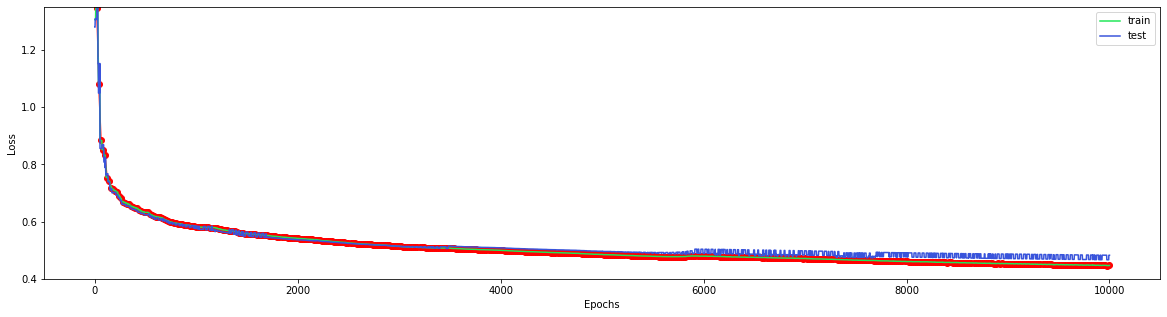

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(loss_history)+1)]
x1 = [20*i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

plt.plot(x1, loss_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, loss_history, label = "train", color= '#20e658')
plt.plot(x, val_loss_history, label = 'test', color = '#3954db')


plt.ylim(ymin=0.4,ymax=1.35)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

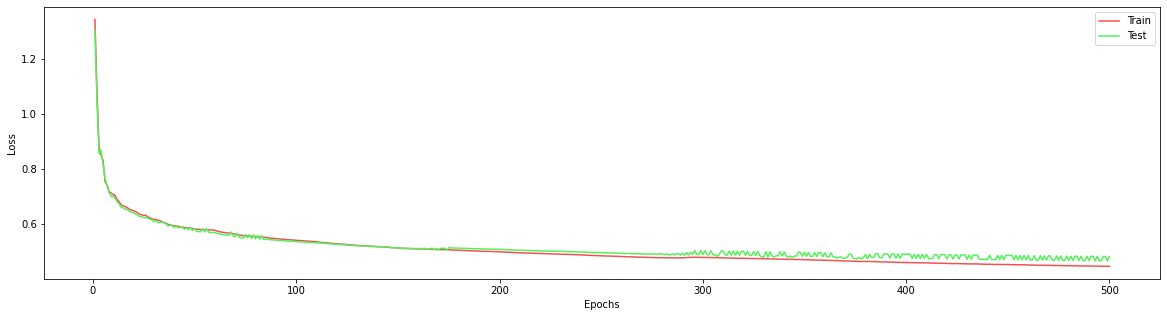

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# x = [i for i in range(1, len(loss_history)+1)]
x1 = [i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

plt.plot(x1, loss_history_epochs, color = '#f25252', label = "Train")
plt.plot(x1, val_loss_history_epochs, color = '#52f258', label = "Test")

# plt.plot(x, loss_history, label = "train", color= '#a89deb')
# plt.plot(x, val_loss_history, label = 'test', color = '#9debb3')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

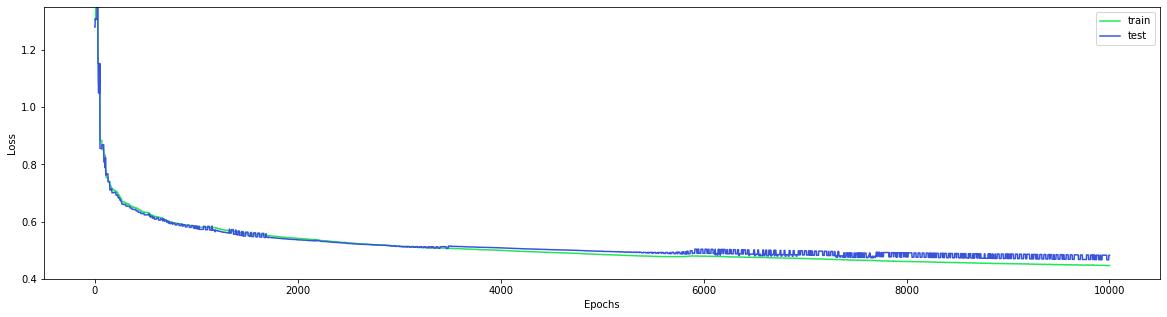

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(loss_history)+1)]
# x1 = [50*i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

# plt.plot(x1, loss_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, loss_history, label = "train", color= '#20e658')
plt.plot(x, val_loss_history, label = 'test', color = '#3954db')
plt.ylim(ymin=0.4,ymax=1.35)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

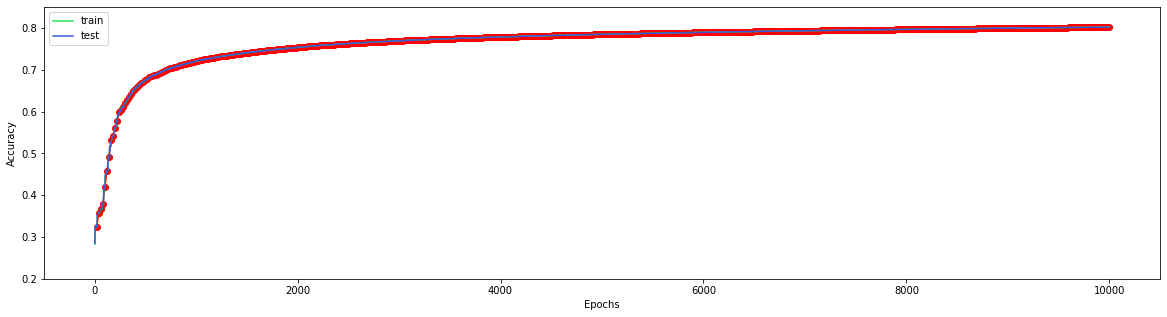

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(acc_history)+1)]
x1 = [20*i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

plt.plot(x1, acc_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, acc_history, label = "train", color= '#20e658')
plt.plot(x, val_acc_history, label = 'test', color = '#3954db')
plt.ylim(ymin=0.2,ymax=0.85)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

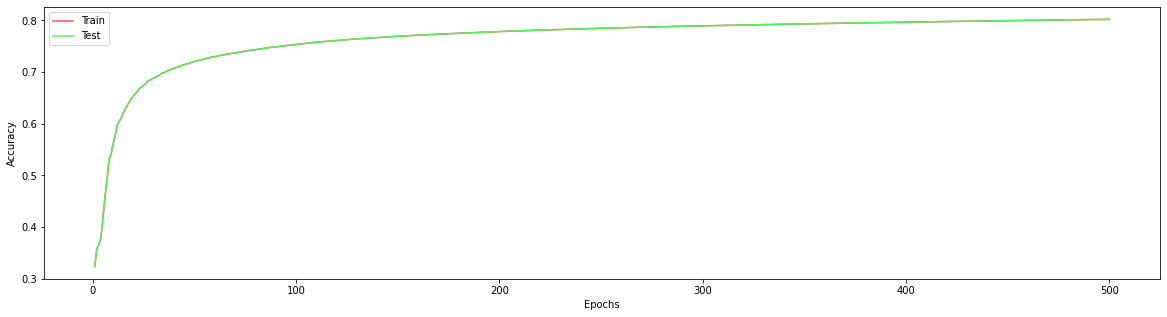

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# x = [i for i in range(1, len(acc_history)+1)]
x1 = [i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

plt.plot(x1, acc_history_epochs, color = '#f25252', label = "Train")
plt.plot(x1, val_acc_history_epochs, color = '#52f258', label = "Test")

# plt.plot(x, acc_history, label = "train", color= '#a89deb')
# plt.plot(x, val_acc_history, label = 'test', color = '#9debb3')
# plt.ylim(ymin=0.2,ymax=0.85)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

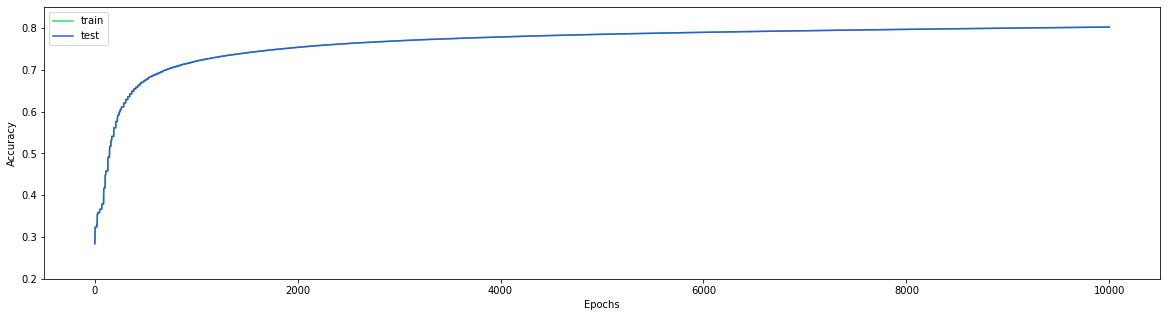

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(acc_history)+1)]
# x1 = [50*i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

# plt.plot(x1, acc_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, acc_history, label = "train", color= '#20e658')
plt.plot(x, val_acc_history, label = 'test', color = '#3954db')
plt.ylim(ymin=0.2,ymax=0.85)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

In [ ]:
for m in molecule:
    print(m.PE.numpy(), m.acc.numpy())

0.45499218 0.801966
0.44899383 0.80198675
0.45588347 0.80195093
0.4520828 0.80196315
0.45443863 0.80195606
0.45044613 0.8019594
0.45254868 0.8019607
0.4530054 0.8019814
0.45625854 0.80196536
0.44841936 0.80196804
0.4559235 0.80197173
0.4560686 0.8019749
0.44667456 0.8019769
0.4555982 0.8019784
0.45141917 0.8019804
0.45799863 0.80198395
0.45450673 0.8019857
0.453936 0.80198944
0.46124583 0.8019909
0.45096964 0.80199236


In [ ]:
molecule_for_cm = best_molecule()
finetune_model.set_weights(weights=molecule_for_cm.weights)
logits = finetune_model(data_x)
y_pred = np.argmax(logits, axis = 1)
from sklearn.metrics import confusion_matrix
confusion_matrix(data_y, y_pred)

array([[1769,   28,    6,    2],
       [  48,  239,   63,   20],
       [  62,  108,  784,   45],
       [  10,   42,  136,  107]])

Text(33.0, 0.5, 'True Label')

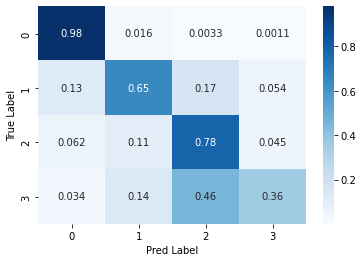

In [ ]:
import seaborn as sns
s = sns.heatmap(confusion_matrix(data_y, y_pred, normalize='true'), cmap='Blues',annot=True)
s.set_xlabel('Pred Label', fontsize=10)
s.set_ylabel('True Label', fontsize=10)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [ ]:
def metrics_calculator(final_molecule):
    train_y_one_hot = np.zeros((data_y.size, 4))
    train_y_one_hot[np.arange(data_y.size),data_y] = 1

    f1_metric = tfa.metrics.F1Score(num_classes=4)
    ck_metric = tfa.metrics.CohenKappa(num_classes=4, sparse_labels=True)
    finetune_model.set_weights(weights=final_molecule.weights)
    logits = finetune_model(data_x)
    f1_metric.update_state(train_y_one_hot, logits)
    f1_result = f1_metric.result()

    ck_metric.update_state(data_y , np.argmax(logits, axis=1))
    ck_result = ck_metric.result()

    p = precision_score(data_y, np.argmax(logits, axis=1), average=None)
    r = recall_score(data_y, np.argmax(logits, axis=1), average=None)
    f = f1_score(data_y, np.argmax(logits, axis=1), average = None)
    ck = cohen_kappa_score(data_y, np.argmax(logits, axis=1))
    acc = accuracy_score(data_y, np.argmax(logits, axis=1))




    print(f1_result.numpy())
    print(ck_result.numpy())
    print(f"Precision : {p}")
    print(f"Recall : {r}")
    print(f"F1 Score : {f}")
    print(f"CK Score : {ck}")
    print(f"Acc Score : {acc}")

In [ ]:
metrics_calculator(best_molecule())

[0.9577694 0.6073698 0.7887324 0.45629  ]
0.7338967
Precision : [0.93647433 0.57314149 0.79271992 0.61494253]
Recall : [0.9800554  0.64594595 0.78478478 0.36271186]
F1 Score : [0.95776936 0.60736976 0.78873239 0.45628998]
CK Score : 0.7338966730523498
Acc Score : 0.8356875180167195


Hello


In [ ]:
save_molecules(molecule, "f1_ck_molecule_weights_20_500")

In [ ]:
histories = BASE_PATH + "f1_ck_history_20_500"
with open(histories, 'wb') as f:
    pickle.dump(loss_history, f)
    pickle.dump(loss_history_epochs, f)
    pickle.dump(acc_history, f)
    pickle.dump(acc_history_epochs, f)
    pickle.dump(val_loss_history, f)
    pickle.dump(val_loss_history_epochs, f)
    pickle.dump(val_acc_history, f)
    pickle.dump(val_acc_history_epochs, f)

100 Epochs
50 Molecule

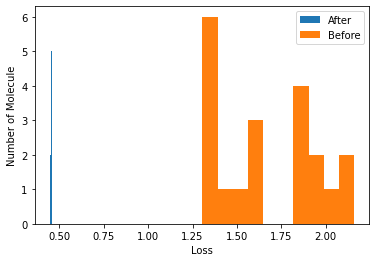

In [ ]:
allPE = []
for m in molecule:
    allPE.append(m.PE)

import matplotlib.pyplot as plt
plt.hist(allPE, label = "After")
plt.hist(molecule_pe_before, label = "Before")
plt.xlabel("Loss")
plt.ylabel("Number of Molecule")
plt.legend()
plt.show()

In [ ]:
max_acc = 0
for i in molecule:
    if i.acc > max_acc:
        max_acc = i.acc

print(max_acc)

tf.Tensor(0.80199236, shape=(), dtype=float32)
